In [1]:
''' magic 4u'''

%load_ext autoreload
%autoreload 2

In [42]:
''' Stuff you need'''

import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.optimize import curve_fit
import ipywidgets as widgets
import seaborn as sns
from pathlib import Path
mpl.rc_file_defaults()

from IPython.core.debugger import set_trace
from pipeline import get_data as get
from pipeline import process_spikes as ps

In [60]:
''' Define formatting for figures '''

from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
''' Load in Animal Metadata '''
animalmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/MouseMetadata.csv') # adjust path name

# define some useful lists of animals based on metadata
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,Age_Month,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,23.487,714,3,6,6
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,23.487,714,3,6,6
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,22.730,691,3,6,6


In [5]:
''' Complete List of Mice & Sessions w/ Included Behavioral Data '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2','052022_record3','052122_record4','052222_record5','052322_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5','062622_record6'], #Y16_1 & 2 not collected
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             [], # all of Y9 omitted b/c bad behavior, end cohort b
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3'], #behavior of A16_4,5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3'], #behavior of MA7_4, 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions


In [6]:
'''Load in Split Maze (SM) session data only'''
# Define mice, sessions for particular cohorts
#mice , mice_ind, _  = np.intersect1d(all_mice,np.union1d(cohorta_mice, cohortb_mice), return_indices = True) # RF mice
mice , mice_ind, _  = np.intersect1d(all_mice, np.union1d(cohortc_mice, cohortd_mice), return_indices = True) # SM mice

print(mice)

sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])
    
# OR select all mice & all sessions
#mice = all_mice
#sessions = all_sessions

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}
        
        
# Load data        
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' # adjust path to match output of Import & Filter MATLAB data

for m, session in zip(mice, sessions):
     for s in session:
        d = data[m][s]
        
        #get file names
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        #load npy files
        d['raw'] = np.load(load_folder + rawdata_file, allow_pickle=True)
        print('loaded raw behavior for mouse ' + m + ' session ' + s)
        d['behaviorfil'] = np.load(load_folder + behavior_file, allow_pickle=False)
        print('loaded filtered behavior for mouse ' + m + ' session ' + s)

['A14' 'A15' 'A16' 'A17' 'A18' 'A19' 'A20' 'A22' 'A23' 'A24' 'MA10F'
 'MA1F' 'MA2F' 'MA3M' 'MA4M' 'MA5M' 'MA6M' 'MA7M' 'MA8F' 'MA9F' 'Y20'
 'Y21' 'Y22' 'Y23' 'Y24' 'Y25' 'Y26' 'Y27' 'Y28']
loaded raw behavior for mouse A14 session 083022_record1
loaded filtered behavior for mouse A14 session 083022_record1
loaded raw behavior for mouse A14 session 083122_record2
loaded filtered behavior for mouse A14 session 083122_record2
loaded raw behavior for mouse A14 session 090122_record3
loaded filtered behavior for mouse A14 session 090122_record3
loaded raw behavior for mouse A15 session 083022_record1
loaded filtered behavior for mouse A15 session 083022_record1
loaded raw behavior for mouse A15 session 083122_record2
loaded filtered behavior for mouse A15 session 083122_record2
loaded raw behavior for mouse A15 session 090122_record3
loaded filtered behavior for mouse A15 session 090122_record3
loaded raw behavior for mouse A15 session 090222_record4
loaded filtered behavior for mouse A15 s

loaded raw behavior for mouse MA2F session 102422_record2
loaded filtered behavior for mouse MA2F session 102422_record2
loaded raw behavior for mouse MA2F session 102522_record3
loaded filtered behavior for mouse MA2F session 102522_record3
loaded raw behavior for mouse MA2F session 102622_record4
loaded filtered behavior for mouse MA2F session 102622_record4
loaded raw behavior for mouse MA2F session 102722_record5
loaded filtered behavior for mouse MA2F session 102722_record5
loaded raw behavior for mouse MA2F session 102822_record6
loaded filtered behavior for mouse MA2F session 102822_record6
loaded raw behavior for mouse MA3M session 102322_record1
loaded filtered behavior for mouse MA3M session 102322_record1
loaded raw behavior for mouse MA3M session 102422_record2
loaded filtered behavior for mouse MA3M session 102422_record2
loaded raw behavior for mouse MA3M session 102522_record3
loaded filtered behavior for mouse MA3M session 102522_record3
loaded raw behavior for mouse MA

loaded filtered behavior for mouse Y24 session 092022_record3
loaded raw behavior for mouse Y24 session 092122_record4
loaded filtered behavior for mouse Y24 session 092122_record4
loaded raw behavior for mouse Y24 session 092222_record5
loaded filtered behavior for mouse Y24 session 092222_record5
loaded raw behavior for mouse Y24 session 092322_record6
loaded filtered behavior for mouse Y24 session 092322_record6
loaded raw behavior for mouse Y25 session 021623_record1
loaded filtered behavior for mouse Y25 session 021623_record1
loaded raw behavior for mouse Y25 session 021723_record2
loaded filtered behavior for mouse Y25 session 021723_record2
loaded raw behavior for mouse Y25 session 021823_record3
loaded filtered behavior for mouse Y25 session 021823_record3
loaded raw behavior for mouse Y25 session 021923_record4
loaded filtered behavior for mouse Y25 session 021923_record4
loaded raw behavior for mouse Y25 session 022023_record5
loaded filtered behavior for mouse Y25 session 0

In [7]:
''' Get reward and lick data ''' 

rewarda_centers = []
rewardb_centers = []

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        raw = d['raw']
        behaviorfil = d['behaviorfil']
        d['reward_data'] = {}
        
        # get behavioral params
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1) # fixes occassional Unity error numbering of rewards 
        
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
         # get reward params & remove reward data pertaining to dark trials & skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            trial = raw.item().get('correctedtrial')
            
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0,np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
                
            skippedtrials = np.setdiff1d(alltrial,np.unique(trial))
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            print('Skipped & dark trials omitted from reward data, n skipped = ' + str(len(skippedtrials)))
            
        except AttributeError:
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
            skippedtrials = []
            print('No trials skipped; only dark trials omitted from reward data')
        
        reward_centers = np.array(reward['centers'][keep_idx])
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        auto_reward = np.array(reward['auto'][keep_idx])
        print('Mouse ' + m + ' with n_misses: ' + str(np.sum(misses)))   

        # get lick and reward indices
        lick_ct = get.spiketrain(post, dt, lickt, index=False)
        d['reward_data']['lick_ct'] = lick_ct
        print('got lick indices for mouse ' + m + ' session ' + s)
        
        reward_idx = get.rewardtrain(post, dt, rewardt, index=True) #gets reward ct for each time binned position range as index
        d['reward_data']['reward_idx'] = reward_idx
        print('got reward indices for mouse ' + m + ' session ' + s)
    
    # saves list of reward locations per mouse
    if reward['centers'][0] == 270:
        rewarda_centers = np.append(rewarda_centers,270)
        rewardb_centers = np.append(rewardb_centers,370)
    else:
        rewarda_centers = np.append(rewarda_centers,370)
        rewardb_centers = np.append(rewardb_centers,270)         

# confirm the correct reward location for each context has been extracted   
print('\nMice; Reward Centers in Context A vs. B')
print(mice)
print(rewarda_centers)
print(rewardb_centers)

Skipped & dark trials omitted from reward data, n skipped = 3
Mouse A14 with n_misses: 183
got lick indices for mouse A14 session 083022_record1
got reward indices for mouse A14 session 083022_record1
Skipped & dark trials omitted from reward data, n skipped = 11
Mouse A14 with n_misses: 154
got lick indices for mouse A14 session 083122_record2
got reward indices for mouse A14 session 083122_record2
Skipped & dark trials omitted from reward data, n skipped = 1
Mouse A14 with n_misses: 145
got lick indices for mouse A14 session 090122_record3
got reward indices for mouse A14 session 090122_record3
No trials skipped; only dark trials omitted from reward data
Mouse A15 with n_misses: 105
got lick indices for mouse A15 session 083022_record1
got reward indices for mouse A15 session 083022_record1
Skipped & dark trials omitted from reward data, n skipped = 1
Mouse A15 with n_misses: 80
got lick indices for mouse A15 session 083122_record2
got reward indices for mouse A15 session 083122_reco

No trials skipped; only dark trials omitted from reward data
Mouse A23 with n_misses: 102
got lick indices for mouse A23 session 021023_record2
got reward indices for mouse A23 session 021023_record2
No trials skipped; only dark trials omitted from reward data
Mouse A23 with n_misses: 52
got lick indices for mouse A23 session 021123_record3
got reward indices for mouse A23 session 021123_record3
No trials skipped; only dark trials omitted from reward data
Mouse A23 with n_misses: 73
got lick indices for mouse A23 session 021223_record4
got reward indices for mouse A23 session 021223_record4
No trials skipped; only dark trials omitted from reward data
Mouse A23 with n_misses: 73
got lick indices for mouse A23 session 021323_record5
got reward indices for mouse A23 session 021323_record5
No trials skipped; only dark trials omitted from reward data
Mouse A23 with n_misses: 3
got lick indices for mouse A23 session 021423_record6
got reward indices for mouse A23 session 021423_record6
No tr

No trials skipped; only dark trials omitted from reward data
Mouse MA8F with n_misses: 70
got lick indices for mouse MA8F session 111422_record2
got reward indices for mouse MA8F session 111422_record2
No trials skipped; only dark trials omitted from reward data
Mouse MA8F with n_misses: 59
got lick indices for mouse MA8F session 111522_record3
got reward indices for mouse MA8F session 111522_record3
No trials skipped; only dark trials omitted from reward data
Mouse MA8F with n_misses: 15
got lick indices for mouse MA8F session 111622_record4
got reward indices for mouse MA8F session 111622_record4
No trials skipped; only dark trials omitted from reward data
Mouse MA8F with n_misses: 9
got lick indices for mouse MA8F session 111722_record5
got reward indices for mouse MA8F session 111722_record5
No trials skipped; only dark trials omitted from reward data
Mouse MA8F with n_misses: 5
got lick indices for mouse MA8F session 111822_record6
got reward indices for mouse MA8F session 111822_

A18
082322_record1real
Con Licks Removed:708, Non-Con Total: 985
082822_record6
Con Licks Removed:1596, Non-Con Total: 1048
MA8F
111322_record1
Con Licks Removed:947, Non-Con Total: 3195
111822_record6
Con Licks Removed:1122, Non-Con Total: 1572
Y25
021623_record1
Con Licks Removed:1024, Non-Con Total: 1205
022123_record6
Con Licks Removed:2758, Non-Con Total: 1494


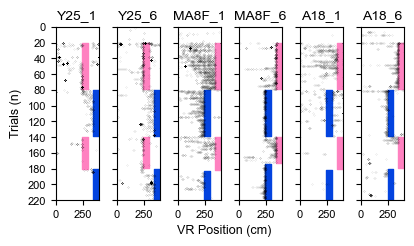

In [9]:
''' Plot Figure 1D '''

fig1d_mice = ['Y25','MA8F','A18']
idxs = [5,6,3,4,1,2]
seshnum = [1,6,1,6,1,6]

count = 0 

fig = plt.figure(figsize = (0.75*len(session),2.25))
nrow = 1
ncol = 6

for m, session in zip(mice, sessions):
    
    if m not in fig1d_mice:
        continue 
    else:
        print(m)
    
    for s in session:
        
        if s in session[1:-1]:
            continue
        else:
            print(s)
        
        #get behavior data
        d = data[m][s]
        raw = d['raw']
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        reward = raw.item().get('reward')
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        
        reward['trials'] = np.arange(0,len(reward['trials']),1)
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        lick_ct = d['reward_data']['lick_ct'].astype(bool)
        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0] 
        
        #remove reward trials/centers corresponding to skipped or darked trials
        try:
            _ = raw.item().get('correctedtrial').shape
            trial = raw.item().get('correctedtrial')
            
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0,np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
                
            skippedtrials = np.setdiff1d(alltrial,np.unique(trial))
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            #print('Skipped & dark trials omitted from reward data, n skipped = ' + str(len(skippedtrials)))
            
        except AttributeError:
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
            skippedtrials = []
            #print('No trials skipped; only dark trials omitted from reward data')
        
        centers = np.array(reward['centers'][keep_idx])
        trials = np.array(reward['trials'][keep_idx])
        
        # remove any consummatory licks, defined as within the reward zone after first reward zone lick
        start_idx = []
        end_idx = []
        for t, c in zip(trials,centers):
            zone_start = (c - 25) #position of beginning of reward zone
            zone_end = (c + 25) #position of end of reward zone
            trial_posx = posx.copy()
            start_trial_ind = np.where(trial == t)[0][0]
            t_posx = trial_posx[trial == t]
            s_idx = np.argmin(np.abs(t_posx - zone_start)) 
            st_idx = np.argmin(np.abs(t_posx - zone_start)) + start_trial_ind
            e_idx = np.argmin(np.abs(t_posx[s_idx:] - zone_end)) + st_idx
    
            if np.sum(lick_ct[st_idx:e_idx]) > 0: 
                l1_idx = st_idx + np.nonzero(lick_ct[st_idx:e_idx])[0][0]
                start_idx.append(l1_idx)
                end_idx.append(e_idx)
            else:
                start_idx.append(st_idx)
                end_idx.append(e_idx)
                
        start_idx = np.asarray(start_idx)
        end_idx = np.asarray(end_idx)
        
        nclick_ct = lick_ct.copy()
        for i in range(start_idx.shape[0]):
            st = start_idx[i]
            e = end_idx[i] + 1
            nclick_ct[st:e] = False
        print('Con Licks Removed:' + str(np.sum(lick_ct) - np.sum(nclick_ct)) + ', Non-Con Total: ' + str(np.sum(nclick_ct)))
        
        # sort lick train, posx by trial type only after trial 140
        right_long = [] #array of 0, 1 that identifies trial as context a vs. b; ensures context a is sorted 1st
        for t in trial:
            try: 
                if left[t] == 1:
                    right_long.append(0)
                else:
                    right_long.append(1)
            except IndexError:
                right_long.append(1)
        right_long = np.asarray(right_long)
                
        altidx = np.where(trial >= 140)[0][0]
        posx_tail = posx[altidx:]
        nclick_ct_tail = nclick_ct[altidx:]
        posx[altidx:] = posx_tail[np.argsort(right_long[altidx:], kind = 'stable')]
        nclick_ct[altidx:] = nclick_ct_tail[np.argsort(right_long[altidx:], kind = 'stable')]
        
        # get reward zone boundaries
        rewarda = centers[20]
        tstarta = 20
        tenda = 79
        rstarta = rewarda - 25
        renda = rewarda + 25
    
        rewardb = centers[80]
        tstartb = 80
        tendb = 139
        rstartb = rewardb - 25
        rendb = rewardb + 25
        
        tstartc = 140
        tendc = tstartc + np.sum(left[np.where(left[139:] == 1)])
        tstartd = tendc + 1
        tendd = tstartd + np.sum(left[np.where(left[139:] == 0)])
        
        #reverse everything
        trial = -1 * trial 
        
        #make raster plots
        idx = idxs[count]
        ax = fig.add_subplot(nrow,ncol,idx)
        ax.plot(posx[nclick_ct], trial[nclick_ct], '.', fillstyle = 'full', markerfacecolor = 'k', markeredgecolor ='k', markersize=0.2, alpha = 0.4)
        ax.set_title(str(m) + '_' + str(seshnum[count]), fontsize = 10)
        ax.set_xlim([0, 400])
        ax.set_ylim([np.min(trial),0])
        ax.set_yticks([-220,-200,-180,-160,-140,-120,-100,-80,-60,-40,-20,0])
        ax.tick_params(labelsize = 8)
        
        if idx == 1:
            ax.set_ylabel('Trials (n)', fontsize = 9)
            ax.set_yticklabels([220,200,180,160,140,120,100,80,60,40,20,0])
        elif idx == 4:
           
            ax.set_yticklabels([])
        else:
            ax.set_yticklabels([])
        
        #context a & b reward zone, c and d ranges are sorted alternation phase trials
        ax.fill_betweenx([-1*tstarta,-1*tenda], [rstarta, rstarta], [renda, renda], color='xkcd:pink', alpha = 1)
        ax.fill_betweenx([-1*tstartb,-1*tendb], [rstartb, rstartb], [rendb, rendb], color='xkcd:blue', alpha = 1)
        ax.fill_betweenx([-1*tstartc,-1*tendc], [rstarta, rstarta], [renda, renda], color='xkcd:pink', alpha = 1)
        ax.fill_betweenx([-1*tstartd,-1*tendd], [rstartb, rstartb], [rendb, rendb], color='xkcd:blue', alpha = 1)
                
        #indicate skipped trial reward zones (or white them out)
        for i in skippedtrials:
            ax.hlines(i, 0,400, color = 'lightgrey', linewidth = 0.5, linestyles = 'dashed')
            
        count += 1

plt.subplots_adjust(hspace = 0.2, wspace = 0.4)
fig.supxlabel('VR Position (cm)', fontsize = 9, y = -0.05)
#fig.savefig(save_folder + m + '_sortedrevcompositelickraster.png', dpi = 400, bbox_inches='tight')
#fig.savefig(save_folder + m + '_sortedrevcompositelickraster.svg', dpi = 400, bbox_inches='tight')
plt.show()

In [ ]:
''' As Figure 1d but generate lick rasters for every sessio, grouped by mouse if desired... '''
save_folder = 'C:/Users/Python/Desktop/LocalData/behaviorsm/lickrasters/sorted/' #adjust path

for m, session in zip(mice, sessions):
    
    fig = plt.figure(figsize = (0.75*len(session),2.25))
    fig.suptitle('Mouse '  + str(m) + ' Licks', fontsize = 10, y = 1.05)
    nrow = 1
    ncol = len(session)
    
    for s in session:
        #get behavior data
        d = data[m][s]
        raw = d['raw']
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        reward = raw.item().get('reward')
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        
        reward['trials'] = np.arange(0,len(reward['trials']),1)
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        lick_ct = d['reward_data']['lick_ct'].astype(bool)
        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0] 
        
        #remove reward trials/centers corresponding to skipped or darked trials
        try:
            _ = raw.item().get('correctedtrial').shape
            trial = raw.item().get('correctedtrial')
            
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0,np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
                
            skippedtrials = np.setdiff1d(alltrial,np.unique(trial))
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            #print('Skipped & dark trials omitted from reward data, n skipped = ' + str(len(skippedtrials)))
            
        except AttributeError:
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
            skippedtrials = []
            #print('No trials skipped; only dark trials omitted from reward data')
        
        centers = np.array(reward['centers'][keep_idx])
        trials = np.array(reward['trials'][keep_idx])
        
        # remove any consummatory licks, defined as within the reward zone after first reward zone lick
        start_idx = []
        end_idx = []
        for t, c in zip(trials,centers):
            zone_start = (c - 25) #position of beginning of reward zone
            zone_end = (c + 25) #position of end of reward zone
            trial_posx = posx.copy()
            start_trial_ind = np.where(trial == t)[0][0]
            t_posx = trial_posx[trial == t]
            s_idx = np.argmin(np.abs(t_posx - zone_start)) 
            st_idx = np.argmin(np.abs(t_posx - zone_start)) + start_trial_ind
            e_idx = np.argmin(np.abs(t_posx[s_idx:] - zone_end)) + st_idx
    
            if np.sum(lick_ct[st_idx:e_idx]) > 0: 
                l1_idx = st_idx + np.nonzero(lick_ct[st_idx:e_idx])[0][0]
                start_idx.append(l1_idx)
                end_idx.append(e_idx)
            else:
                start_idx.append(st_idx)
                end_idx.append(e_idx)
                
        start_idx = np.asarray(start_idx)
        end_idx = np.asarray(end_idx)
        
        nclick_ct = lick_ct.copy()
        for i in range(start_idx.shape[0]):
            st = start_idx[i]
            e = end_idx[i] + 1
            nclick_ct[st:e] = False
        print('Con Licks Removed:' + str(np.sum(lick_ct) - np.sum(nclick_ct)) + ', Non-Con Total: ' + str(np.sum(nclick_ct)))
        
        # sort lick train, posx by trial type only after trial 140
        right_long = [] #array of 0, 1 that identifies trial as context a vs. b; ensures context a is sorted 1st
        for t in trial:
            try: 
                if left[t] == 1:
                    right_long.append(0)
                else:
                    right_long.append(1)
            except IndexError:
                right_long.append(1)
        right_long = np.asarray(right_long)
                
        altidx = np.where(trial >= 140)[0][0]
        posx_tail = posx[altidx:]
        nclick_ct_tail = nclick_ct[altidx:]
        posx[altidx:] = posx_tail[np.argsort(right_long[altidx:], kind = 'stable')]
        nclick_ct[altidx:] = nclick_ct_tail[np.argsort(right_long[altidx:], kind = 'stable')]
        
        # get reward zone boundaries
        rewarda = centers[20]
        tstarta = 20
        tenda = 79
        rstarta = rewarda - 25
        renda = rewarda + 25
    
        rewardb = centers[80]
        tstartb = 80
        tendb = 139
        rstartb = rewardb - 25
        rendb = rewardb + 25
        
        tstartc = 140
        tendc = tstartc + np.sum(left[np.where(left[139:] == 1)])
        tstartd = tendc + 1
        tendd = tstartd + np.sum(left[np.where(left[139:] == 0)])
        
        #reverse everything
        trial = -1 * trial 
        
        #make raster plots
        idx = np.where(np.asarray(session) == s)[0][0] + 1
        ax = fig.add_subplot(nrow,ncol,idx)
        ax.plot(posx[nclick_ct], trial[nclick_ct], '.', fillstyle = 'full', markerfacecolor = 'k', markeredgecolor ='k', markersize=0.2, alpha = 0.4)
        ax.set_title('Sess. ' + str(idx), fontsize = 10)
        ax.set_xlim([0, 400])
        ax.set_ylim([np.min(trial),0])
        ax.set_yticks([-220,-200,-180,-160,-140,-120,-100,-80,-60,-40,-20,0])
        ax.tick_params(labelsize = 8)
        
        if idx == 1:
            ax.set_ylabel('Trials (n)', fontsize = 9)
            ax.set_yticklabels([220,200,180,160,140,120,100,80,60,40,20,0])
        elif idx == 4:
            ax.set_xlabel('VR Position (cm)', fontsize = 9, x = -1.7)
            ax.set_yticklabels([])
        else:
            ax.set_yticklabels([])
        
        #context a & b reward zone, c and d ranges are sorted alternation phase trials
        ax.fill_betweenx([-1*tstarta,-1*tenda], [rstarta, rstarta], [renda, renda], color='xkcd:pink', alpha = 1)
        ax.fill_betweenx([-1*tstartb,-1*tendb], [rstartb, rstartb], [rendb, rendb], color='xkcd:blue', alpha = 1)
        ax.fill_betweenx([-1*tstartc,-1*tendc], [rstarta, rstarta], [renda, renda], color='xkcd:pink', alpha = 1)
        ax.fill_betweenx([-1*tstartd,-1*tendd], [rstartb, rstartb], [rendb, rendb], color='xkcd:blue', alpha = 1)
                
        #indicate skipped trial reward zones (or white them out)
        for i in skippedtrials:
            ax.hlines(i, 0,400, color = 'lightgrey', linewidth = 0.5, linestyles = 'dashed')

    plt.subplots_adjust(hspace = 0.2, wspace = 0.4)
    #fig.savefig(save_folder + m + '_sortedrevcompositelickraster.png', dpi = 400, bbox_inches='tight')
    #fig.savefig(save_folder + m + '_sortedrevcompositelickraster.svg', dpi = 400, bbox_inches='tight')
    plt.show()

In [10]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
ma_ind = []
y_ind = []
age_sind = []
ma_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    elif m in all_MA_mice:
        ma_ind = np.append(ma_ind, (np.where(mice == m)[0]))
        ma_sind = np.append(ma_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
ma_ind = ma_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
ma_sind = ma_sind.astype(int)
y_sind = y_sind.astype(int)

print('SM Task: n_young mice, n_MA_mice, n_aged mice')
print(len(mice[y_ind]), len(mice[ma_ind]), len(mice[age_ind]))
print('\nSM Task: n_young sesh, n_MA sesh, n_aged sesh')
print(len(y_sind), len(ma_sind), len(age_sind))
Nold = len(mice[age_ind])
Nma = len(mice[ma_ind])
Nyoung = len(mice[y_ind])

SM Task: n_young mice, n_MA_mice, n_aged mice
9 10 10

SM Task: n_young sesh, n_MA sesh, n_aged sesh
54 55 54


In [11]:
'''Get Number of Mice & Sessions in each Age Group per Metadata (Make Sure this Matches Above)'''

print('\nN_aged_SM (Total: Female, Male): ' + str(len(SM_aged_mice)) + ': ' + str(len(np.intersect1d(SM_aged_mice, SM_female_mice))) + ' , ' + str(len(np.intersect1d(SM_aged_mice, SM_male_mice))))
print('SM_aged Sessions: ' + str(np.sum(np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Behavior_Sessions']))))

print('\nN_MA_SM (Total: Female, Male): ' + str(len(SM_MA_mice)) + ': ' + str(len(np.intersect1d(SM_MA_mice, SM_female_mice))) + ' , ' + str(len(np.intersect1d(SM_MA_mice, SM_male_mice))))
print('SM_MA Sessions: ' + str(np.sum(np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Behavior_Sessions']))))

print('\nN_young_SM (Total: Female, Male): ' + str(len(SM_young_mice)) + ': ' + str(len(np.intersect1d(SM_young_mice, SM_female_mice))) + ' , ' + str(len(np.intersect1d(SM_young_mice, SM_male_mice))))
print('SM_young Sessions: ' + str(np.sum(np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Behavior_Sessions']))))

N_old= np.sum(np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Behavior_Sessions']))
Nold = len(SM_aged_mice)
N_old = np.sum(np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Behavior_Sessions']))

N_ma = np.sum(np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Behavior_Sessions']))
Nma = len(SM_MA_mice)
N_ma = np.sum(np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Behavior_Sessions']))

#Confirm that this will segment the data appropriately
print(mice[age_ind])
print(mice[Nold:(Nma+Nold)])
print(mice[(Nma+Nold):])


N_aged_SM (Total: Female, Male): 10: 5 , 5
SM_aged Sessions: 54

N_MA_SM (Total: Female, Male): 10: 5 , 5
SM_MA Sessions: 55

N_young_SM (Total: Female, Male): 9: 5 , 4
SM_young Sessions: 54
['A14' 'A15' 'A16' 'A17' 'A18' 'A19' 'A20' 'A22' 'A23' 'A24']
['MA10F' 'MA1F' 'MA2F' 'MA3M' 'MA4M' 'MA5M' 'MA6M' 'MA7M' 'MA8F' 'MA9F']
['Y20' 'Y21' 'Y22' 'Y23' 'Y24' 'Y25' 'Y26' 'Y27' 'Y28']


In [12]:
''' Define ColorMaps for Plot by Mouse Name '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,10)])
col_animal_MA = pl.cm.Greens([np.linspace(0.2,0.9,10)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,9)])
col_animal = [col_animal_young, col_animal_MA, col_animal_old]

col_session_young = []
col_session_MA = []
col_session_old = []

for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in SM_aged_mice:
            idx = np.where(mice == m)[0][0] 
            col_session_old.append(col_animal[2][0][idx])           
        elif m in SM_MA_mice:
            idx = np.where(mice == m)[0][0] - Nold
            col_session_MA.append(col_animal[1][0][idx])
        else:
            idx = np.where(mice == m)[0][0] - (Nold + Nma)
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young, col_session_MA, col_session_old]
label_mice = ['Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28', "",
              'MA10F', 'MA1F', 'MA2F', 'MA3M', 'MA4M', 'MA5M', 'MA6M', 'MA7M', 'MA8F', 'MA9F',
              'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A22', 'A23', 'A24']

In [13]:
''' Find & Save Number of Missed Rewards per Session & Animal'''
#block array
blocksatiety = []
blockreq = []
blocktrialn = []

#session arrays
req_rates = []
reqa_rates = []
reqb_rates = []
reqblock_rates = []
reqalt_rates = []
reqalta_rates = []
reqaltb_rates = []
req_trials = []
reqblock_trials = []
reqalt_trials = []

#animals arrays
mreq_rates = []
mreqa_rates = []
mreqb_rates = []
mreqblock_rates = []
mreqalt_rates = []
mreqalta_rates = []
mreqaltb_rates = []

for m, session in zip(mice, sessions):
    rt = []
    ca = []
    cb = []
    blocks = []
    alt = []
    alta = []
    altb = []
    
    req = []
    reqa = []
    reqb = []
    reqblocks = []
    reqalt = []
    reqalta = []
    reqaltb = []
    
    for s in session:
        # get behavior data
        d = data[m][s]
        raw = d['raw']
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1)
        
        try:
            _ = raw.item().get('correctedtrial').shape
            trial = raw.item().get('correctedtrial')
            
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0,np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
                
            skippedtrials = np.setdiff1d(alltrial,np.unique(trial))
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            #print('Skipped & dark trials omitted from reward data, n skipped = ' + str(len(skippedtrials)))
            
        except AttributeError:
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
            skippedtrials = []
            #print('No trials skipped; only dark trials omitted from reward data')
        
        reward_centers = np.array(reward['centers'][keep_idx])
        rewarda = reward_centers[0]
        rewardb = reward_centers[60]
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        requests = ~misses
        
        # find rate of requests for a given session
        req_rates.append(np.sum(requests)/len(reward_trials)) #total
        
        rewarda_idx = np.where(reward_trials < 81)[0]
        reqa_rates.append(np.sum(requests[rewarda_idx])/len(rewarda_idx)) #context a
        
        rewardb_idx = np.intersect1d((np.where(reward_trials >= 81)), (np.where(reward_trials <= 140)))
        reqb_rates.append(np.sum(requests[rewardb_idx])/len(rewardb_idx)) #context b
        
        block_idx = np.where(reward_trials < 140)[0]
        reqblock_rates.append(np.sum(requests[block_idx])/len(block_idx)) #block
        
        alt_idx = np.where(reward_trials >= 140)[0]
        reqalt_rates.append(np.sum(requests[alt_idx])/len(alt_idx)) #alt
        
        alta_idx = np.where((reward_trials >= 140) & (reward_centers == rewarda))[0] 
        reqalta_rates.append(np.mean(requests[alta_idx]))
        
        altb_idx = np.where((reward_trials >= 140) & (reward_centers == rewardb))[0]
        reqaltb_rates.append(np.mean(requests[altb_idx]))
        
        rt = np.append(rt,len(reward_trials))
        ca = np.append(ca,len(rewarda_idx))
        cb = np.append(cb,len(rewardb_idx))
        blocks = np.append(blocks,len(block_idx))
        alt = np.append(alt,len(alt_idx))
        alta = np.append(alta, len(alta_idx))
        altb = np.append(altb, len(altb_idx))
        
        req_trials = np.append(req_trials, len(reward_trials))
        reqblock_trials = np.append(reqblock_trials, len(block_idx))
        reqalt_trials = np.append(reqalt_trials, len(alt_idx))
        
        req = np.append(req,np.sum(requests))
        reqa = np.append(reqa,np.sum(requests[rewarda_idx]))
        reqb = np.append(reqb,np.sum(requests[rewardb_idx]))
        reqblocks = np.append(reqblocks,np.sum(requests[block_idx]))
        reqalt = np.append(reqalt,np.sum(requests[alt_idx]))
        reqalta = np.append(reqalta,requests[alta_idx])
        reqaltb = np.append(reqaltb,requests[altb_idx])
        
        # append req rates from blocks into block req array len(4 x total sessions)
        blockreq = np.append(blockreq, np.mean(requests[rewarda_idx])) # block 1
        blockreq = np.append(blockreq, np.mean(requests[rewardb_idx])) # block 2
        blockreq = np.append(blockreq, np.mean(requests[alta_idx])) # block 3
        blockreq = np.append(blockreq, np.mean(requests[altb_idx])) # block 4   
        
        blocktrialn = np.append(blocktrialn, len(requests[rewarda_idx]))
        blocktrialn = np.append(blocktrialn, len(requests[rewardb_idx]))
        blocktrialn = np.append(blocktrialn, len(requests[alta_idx]))
        blocktrialn = np.append(blocktrialn, len(requests[altb_idx]))
        
        # append reward counts from previous task block into block satiety array len(4 x total sessions)
        blocksatiety = np.append(blocksatiety, 0) #no rewards before block a for every animal
        blocksatiety = np.append(blocksatiety, np.sum(requests[rewarda_idx])) # count of rewards consumed before block b
        blocksatiety = np.append(blocksatiety, (np.sum(requests[rewarda_idx]) + np.sum(requests[rewardb_idx]))) # before alta
        blocksatiety = np.append(blocksatiety, (np.sum(requests[rewarda_idx]) + np.sum(requests[rewardb_idx]) + np.sum(requests[alta_idx]))) # beforealtb             
                          
    # get mouse request rate collapsing days
    mreqrate = np.sum(req)/ np.sum(rt)
    mreq_rates = np.append(mreq_rates,mreqrate)
    
    mreqarate = np.sum(reqa) / np.sum(ca)
    mreqa_rates = np.append(mreqa_rates, mreqarate)
    
    mreqbrate = np.sum(reqb) / np.sum(cb)
    mreqb_rates = np.append(mreqb_rates, mreqbrate)
    
    mreqblockrate = np.sum(reqblocks) / np.sum(blocks)
    mreqblock_rates = np.append(mreqblock_rates, mreqblockrate)
    
    mreqaltrate = np.sum(reqalt) / np.sum(alt)
    mreqalt_rates = np.append(mreqalt_rates, mreqaltrate)
    
    mreqalta_rates = np.append(mreqalta_rates, np.mean(reqalta))
    mreqaltb_rates = np.append(mreqaltb_rates, np.mean(reqaltb))
    
# save as arrays to be safe
req_rates = np.asarray(req_rates)
reqa_rates = np.asarray(reqa_rates)
reqb_rates = np.asarray(reqb_rates)
reqblock_rates = np.asarray(reqblock_rates)
reqalt_rates = np.asarray(reqalt_rates)
reqalta_rates = np.asarray(reqalta_rates)
reqaltb_rates = np.asarray(reqaltb_rates)

mreq_rates = np.asarray(mreq_rates)
mreqa_rates = np.asarray(mreqa_rates)
mreqb_rates = np.asarray(mreqb_rates)
mreqblock_rates = np.asarray(mreqblock_rates)
mreqalt_rates = np.asarray(mreqalt_rates)
mreqalta_rates = np.asarray(reqalta_rates)
mreqaltb_rates = np.asarray(reqaltb_rates)

blocksatiety = np.asarray(blocksatiety)
blockreq = np.asarray(blockreq)
blocktrialn = np.asarray(blocktrialn)

In [14]:
'''Store Session 1 - 6 for Alt & Block in Nested List'''
r = 6
reqaltseg_aged = [[] * r for i in range(r)]
reqseg_aged = [[] * r for i in range(r)]
reqblockseg_aged= [[] * r for i in range(r)]

reqaltseg_MA = [[] * r for i in range(r)]
reqseg_MA = [[] * r for i in range(r)]
reqblockseg_MA= [[] * r for i in range(r)]

reqaltseg_young = [[] * r for i in range(r)]
reqseg_young = [[] * r for i in range(r)]
reqblockseg_young= [[] * r for i in range(r)]

count = 0
for m, session in zip(mice, sessions): 
    
    session_idx = np.arange(0 + count, len(session) + count)
    count += len(session)
    
    if m in SM_aged_mice:
        for s in range(0, len(session_idx)):
            reqaltseg_aged[s] = np.append(reqaltseg_aged[s],reqalt_rates[session_idx][s])
            reqblockseg_aged[s] = np.append(reqblockseg_aged[s],reqblock_rates[session_idx][s])
            reqseg_aged[s] = np.append(reqseg_aged[s],req_rates[session_idx][s])
            
    elif m in SM_MA_mice:
        for s in range(0, len(session_idx)):
            reqaltseg_MA[s] = np.append(reqaltseg_MA[s],reqalt_rates[session_idx][s])
            reqblockseg_MA[s] = np.append(reqblockseg_MA[s],reqblock_rates[session_idx][s]) 
            reqseg_MA[s] = np.append(reqseg_MA[s],req_rates[session_idx][s])
    else:
        for s in range(0, len(session_idx)):
            reqaltseg_young[s] = np.append(reqaltseg_young[s],reqalt_rates[session_idx][s])
            reqblockseg_young[s] = np.append(reqblockseg_young[s],reqblock_rates[session_idx][s]) 
            reqseg_young[s] = np.append(reqseg_young[s],req_rates[session_idx][s])

#find means & SEM for each age group over time for alt phase & block phase
reqalt_meanaged = []
reqalt_erraged = []
reqblock_meanaged = []
reqblock_erraged = []
req_meanaged = []
req_erraged = []

for i in range(0,len(reqaltseg_aged)):
    reqalt_meanaged = np.append(reqalt_meanaged,np.mean(reqaltseg_aged[i]))
    reqalt_erraged = np.append(reqalt_erraged,stats.sem(reqaltseg_aged[i]))
    reqblock_meanaged = np.append(reqblock_meanaged,np.mean(reqblockseg_aged[i]))
    reqblock_erraged = np.append(reqblock_erraged,stats.sem(reqblockseg_aged[i]))
    req_meanaged = np.append(req_meanaged,np.mean(reqseg_aged[i]))
    req_erraged = np.append(req_erraged,stats.sem(reqseg_aged[i]))
    
    
reqalt_meanMA = []
reqalt_errMA = []
reqblock_meanMA = []
reqblock_errMA = []
req_meanMA = []
req_errMA = []

for i in range(0,len(reqaltseg_MA)):
    reqalt_meanMA = np.append(reqalt_meanMA,np.mean(reqaltseg_MA[i]))
    reqalt_errMA = np.append(reqalt_errMA,stats.sem(reqaltseg_MA[i]))
    reqblock_meanMA = np.append(reqblock_meanMA,np.mean(reqblockseg_MA[i]))
    reqblock_errMA = np.append(reqblock_errMA,stats.sem(reqblockseg_MA[i]))
    req_meanMA = np.append(req_meanMA,np.mean(reqseg_MA[i]))
    req_errMA = np.append(req_errMA,stats.sem(reqseg_MA[i]))
    
reqalt_meanyoung = []
reqalt_erryoung = []
reqblock_meanyoung = []
reqblock_erryoung = []
req_meanyoung = []
req_erryoung = []

for i in range(0,len(reqaltseg_young)):
    reqalt_meanyoung = np.append(reqalt_meanyoung,np.mean(reqaltseg_young[i]))
    reqalt_erryoung = np.append(reqalt_erryoung,stats.sem(reqaltseg_young[i]))
    reqblock_meanyoung = np.append(reqblock_meanyoung,np.mean(reqblockseg_young[i]))
    reqblock_erryoung = np.append(reqblock_erryoung,stats.sem(reqblockseg_young[i]))
    req_meanyoung = np.append(req_meanyoung,np.mean(reqseg_young[i]))
    req_erryoung = np.append(req_erryoung,stats.sem(reqseg_young[i]))

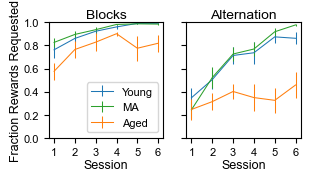

In [15]:
''' Plot Figure 1e'''

f, ax = plt.subplots(1, 2, figsize=(3.25, 1.5), sharey = True)
ax[0].errorbar(np.arange(1,7,1),reqblock_meanyoung,yerr = reqblock_erryoung, linewidth = 0.75, label = 'Young', color = 'C0')
ax[0].errorbar(np.arange(1,7,1),reqblock_meanMA,yerr = reqblock_errMA, linewidth = 0.75, label = 'MA', color = 'C2')
ax[0].errorbar(np.arange(1,7,1),reqblock_meanaged,yerr = reqblock_erraged, linewidth = 0.75, label = 'Aged', color = 'C1')
ax[0].set_title('Blocks', fontsize=10, pad=3)
ax[0].set_ylim((0,1))
ax[0].set_xticks((1,2,3,4,5,6))
ax[0].set_ylabel('Fraction Rewards Requested', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
ax[0].legend(loc = 4, fontsize = 8)
ax[0].tick_params(labelsize = 8)

ax[1].errorbar(np.arange(1,7,1),reqalt_meanyoung,yerr = reqalt_erryoung, linewidth = 0.75, label = 'Young', color = 'C0')
ax[1].errorbar(np.arange(1,7,1),reqalt_meanMA,yerr = reqalt_errMA, linewidth = 0.75, label = 'MA', color = 'C2')
ax[1].errorbar(np.arange(1,7,1),reqalt_meanaged,yerr = reqalt_erraged, linewidth = 0.75, label = 'Aged', color = 'C1')
ax[1].set_title('Alternation', fontsize=10, pad=3)
ax[1].set_ylim((0,1))
#ax[1].set_ylabel('Fraction Rewards Requested', fontsize=9, labelpad=1)
ax[1].set_xticks((1,2,3,4,5,6))
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)

#plt.savefig(save_folder + 'time_reqrewards_composite_avganimal.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'time_reqrewards_composite_avganimal.svg', dpi=400, bbox_inches='tight')
plt.show()

In [16]:
''' Define Save Folder for Next Plots & a List of Sex, Reward A, Mouse ID, Session Count, for Sessions'''
save_folder = 'C:/Users/Python/Desktop/LocalData/behaviorsm/'
sex = list(animalmeta.Sex[mice_ind])
rewardacenters = []
sexes = []
seshmice = []
seshcount = []
seshage = []
seshagem = []
for m, session in zip(mice, sessions):
    center = rewarda_centers[np.where(mice == m)[0][0]]
    msex = sex[np.where(mice == m)[0][0]]
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    agem = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Month']) # represents age on last recording / sac day
    totalsesh = len(session)
    
    for i, s in enumerate(session):
        rewardacenters = np.append(rewardacenters, center)
        sexes = np.append(sexes, msex)
        seshmice = np.append(seshmice, m)
        seshcount = np.append(seshcount, (i + 1))
        seshage = np.append(seshage, age)
        if (i + 1) == len(session):
            realage = agem
        else:
            realage = agem - (totalsesh - (i + 1))*0.033 # approximates age on a given recording day
        seshagem = np.append(seshagem, realage)

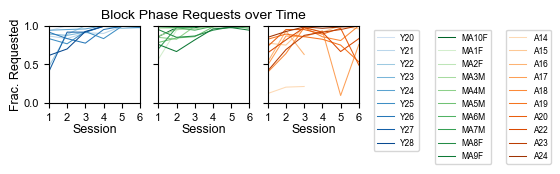

In [17]:
''' Plot Figure 1j (top) '''

LW = 0.75

count = 0
f, ax = plt.subplots(1, 3, figsize=(4, 1), sharey = True)

for m, session in zip(mice, sessions): 
    session_idx = np.arange(0 + count, len(session) + count)
    count += len(session)
    
    if m in SM_young_mice:
        i = np.where(SM_young_mice == m)[0][0]
        sesh = np.arange(1,(len(session)+1))
        reqblock = reqblock_rates[session_idx]
        ax[0].plot(sesh,reqblock,label = str(m), color = col_animal_young[0][i], linewidth = 0.75)
    elif m in SM_MA_mice:
        i = np.where(SM_MA_mice == m)[0][0]
        sesh = np.arange(1,(len(session)+1))
        reqblock = reqblock_rates[session_idx]
        ax[1].plot(sesh, reqblock, label = str(m), color = col_animal_MA[0][i], linewidth = 0.75)
    else:
        i = np.where(SM_aged_mice == m)[0][0]
        sesh = np.arange(1,(len(session)+1))
        reqblock = reqblock_rates[session_idx]
        ax[2].plot(sesh,reqblock,label = str(m), color = col_animal_old[0][i], linewidth = 0.75)

ax[1].set_title('Block Phase Requests over Time', fontsize=10, pad = 5)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[2].set_xlabel('Session', fontsize=9, labelpad=1)
ax[0].set_ylabel('Frac. Requested', fontsize=9, labelpad=1)
ax[0].set_xlim([1,6])
ax[0].set_ylim([0,1])
ax[1].set_xlim([1,6])
ax[2].set_xlim([1,6])
ax[0].set_xticks([1,2,3,4,5,6])
ax[1].set_xticks([1,2,3,4,5,6])
ax[2].set_xticks([1,2,3,4,5,6])
ax[0].set_yticks([0, 0.5, 1])
ax[0].tick_params(labelsize = 8)
ax[1].tick_params(labelsize = 8)
ax[2].tick_params(labelsize = 8)

# add or hide legends
ax[0].legend(bbox_to_anchor=(4.1, 1), fontsize = 6)
ax[1].legend(bbox_to_anchor=(3.7, 1), fontsize = 6)
ax[2].legend(bbox_to_anchor=(3.15, 1), fontsize = 6)

#plt.savefig(save_folder + 'time_reqblockrewards_animal.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'time_reqblockrewards_animal.svg', dpi=400, bbox_inches='tight')
plt.show()

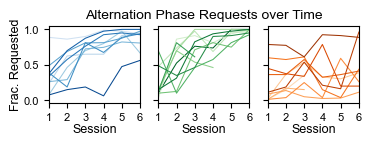

In [18]:
''' Plot Figure 1j (bottom)'''

count = 0
f, ax = plt.subplots(1, 3, figsize=(4, 1), sharey = True)
for m, session in zip(mice, sessions): 
    session_idx = np.arange(0 + count, len(session) + count)
    count += len(session)
    
    if m in SM_young_mice:
        i = np.where(SM_young_mice == m)[0][0]
        sesh = np.arange(1,(len(session)+1))
        reqalt = reqalt_rates[session_idx]
        ax[0].plot(sesh,reqalt,label = str(m), color = col_animal_young[0][i], linewidth = 0.75)
    elif m in SM_MA_mice:
        i = np.where(SM_MA_mice == m)[0][0]
        sesh = np.arange(1,(len(session)+1))
        reqalt = reqalt_rates[session_idx]
        ax[1].plot(sesh, reqalt, label = str(m), color = col_animal_MA[0][i], linewidth = 0.75)
    else:
        i = np.where(SM_aged_mice == m)[0][0]
        sesh = np.arange(1,(len(session)+1))
        reqalt = reqalt_rates[session_idx]
        ax[2].plot(sesh,reqalt,label = str(m), color = col_animal_old[0][i], linewidth = 0.75)

ax[1].set_title('Alternation Phase Requests over Time', fontsize=10, pad = 5)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[2].set_xlabel('Session', fontsize=9, labelpad=1)
ax[0].set_ylabel('Frac. Requested', fontsize=9, labelpad=1)
ax[0].set_xlim([1,6])
ax[1].set_xlim([1,6])
ax[2].set_xlim([1,6])
ax[0].set_xticks([1,2,3,4,5,6])
ax[1].set_xticks([1,2,3,4,5,6])
ax[2].set_xticks([1,2,3,4,5,6])
ax[0].set_yticks([0, 0.5, 1])
ax[0].tick_params(labelsize = 8)
ax[1].tick_params(labelsize = 8)
ax[2].tick_params(labelsize = 8)

#plt.savefig(save_folder + 'time_reqaltrewards_animal.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'time_reqaltrewards_animal.svg', dpi=400, bbox_inches='tight')
plt.show()

In [19]:
'''Give Alt. Performance Percentile of each animal in its age group, overall '''

count = -1
for m, session in zip(mice, sessions): 
    count += 1
    
    if m in SM_aged_mice:
        percentile = stats.percentileofscore(mreqalt_rates[age_ind], mreqalt_rates[count])
        overall = np.round(stats.percentileofscore(mreqalt_rates, mreqalt_rates[count]),1)
        print(m, percentile, overall)
    elif m in SM_MA_mice:
        percentile = stats.percentileofscore(mreqalt_rates[ma_ind], mreqalt_rates[count])
        overall = np.round(stats.percentileofscore(mreqalt_rates, mreqalt_rates[count]),1)
        print(m, percentile, overall)
    else:
        percentile = stats.percentileofscore(mreqalt_rates[y_ind], mreqalt_rates[count])
        overall = np.round(stats.percentileofscore(mreqalt_rates, mreqalt_rates[count]),1)
        print(m, percentile, overall)

A14 30.0 10.3
A15 50.0 20.7
A16 20.0 6.9
A17 10.0 3.4
A18 40.0 13.8
A19 90.0 34.5
A20 80.0 31.0
A22 70.0 27.6
A23 60.0 24.1
A24 100.0 93.1
MA10F 60.0 69.0
MA1F 80.0 79.3
MA2F 90.0 86.2
MA3M 100.0 89.7
MA4M 10.0 37.9
MA5M 30.0 44.8
MA6M 40.0 51.7
MA7M 20.0 41.4
MA8F 50.0 65.5
MA9F 70.0 72.4
Y20 100.0 100.0
Y21 55.55555555555556 62.1
Y22 22.22222222222222 48.3
Y23 33.33333333333333 55.2
Y24 77.77777777777777 82.8
Y25 44.44444444444444 58.6
Y26 66.66666666666666 75.9
Y27 88.88888888888889 96.6
Y28 11.11111111111111 17.2


C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       ReqBlock
No. Observations:        163           Method:                   REML    
No. Groups:              29            Scale:                    0.0140  
Min. group size:         3             Log-Likelihood:           67.1225 
Max. group size:         6             Converged:                Yes     
Mean group size:         5.6                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.768    0.077 10.032 0.000  0.618  0.918
C(AgeGroup)[T.2.0]              0.035    0.104  0.339 0.735 -0.168  0.239
C(AgeGroup)[T.3.0]             -0.182    0.103 -1.757 0.079 -0.384  0.021
C(Sex)[T.M]                    -0.038    0.054 -0.692 0.

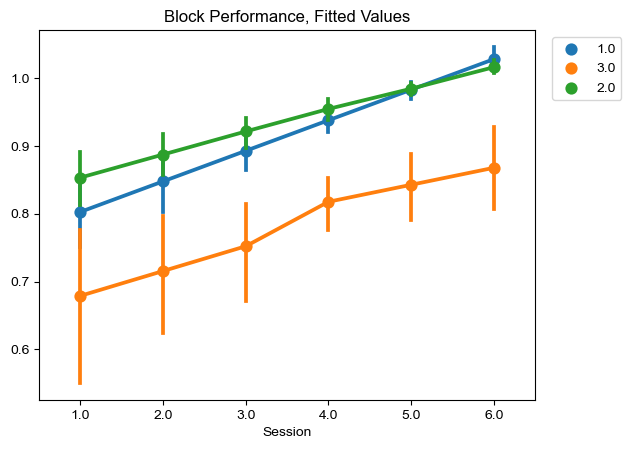

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                        Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           ReqAlt 
No. Observations:             163               Method:                       REML   
No. Groups:                   29                Scale:                        0.0310 
Min. group size:              3                 Log-Likelihood:               10.0100
Max. group size:              6                 Converged:                    Yes    
Mean group size:              5.6                                                    
-------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                   0.373    0.111  3.372 0.001  0.156  0.589
C(AgeGroup)[T.2.0]                         -0.096    0.156 -0.618 0.537 -0.403

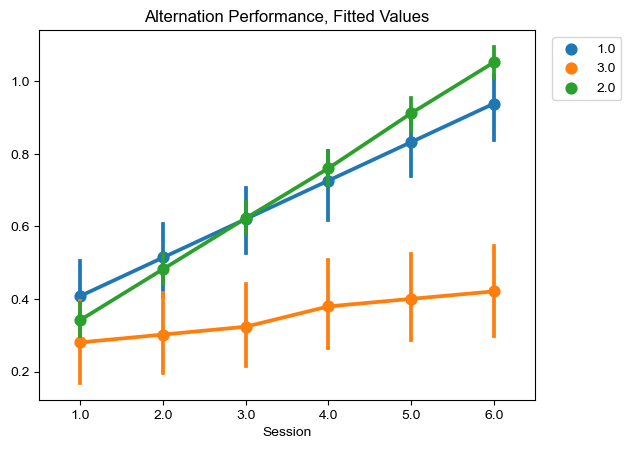

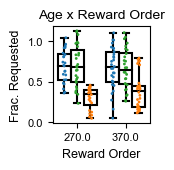

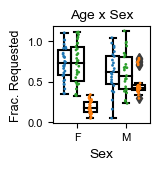

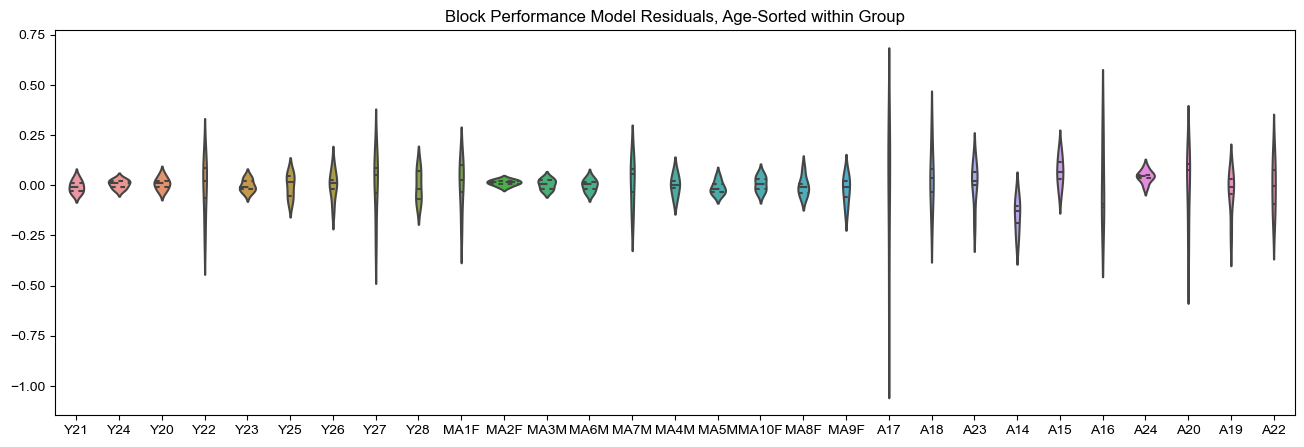

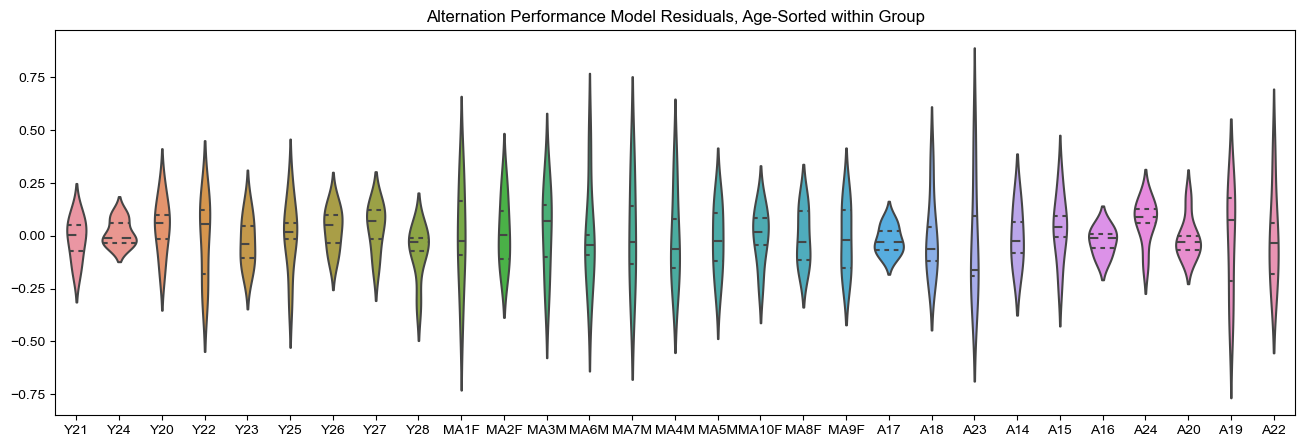

In [20]:
''' Run SM Block vs. Alternation Performance LMMs & Plot Extended Data Figure 1g'''
save_folder = 'C:/Users/Python/Desktop/LocalData/behaviorsm/'

new_palette =  sns.color_palette(n_colors = 3)
new_palette[1], new_palette[2] = new_palette[2], new_palette[1]

# Collect all relevant data into pandas dataframe
Animal_ID = list(seshmice)
Session = list(seshcount)
Sex = list(sexes)
Age = list(seshagem)
Age_Group = list(seshage)
Reward_Order = list(rewardacenters)
ReqBlock = list(reqblock_rates)
ReqAlt = list(reqalt_rates)
TotalReq = list(req_rates)

tuples = list(zip(Animal_ID, Session, Sex, Age, Age_Group, Reward_Order, ReqBlock, ReqAlt, TotalReq))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'Sex', 'Age', 'AgeGroup','RewardOrder','ReqBlock','ReqAlt','TotalReq'])

'''
Model Construction Thoughts:
1. Fixed effects are age, sex, reward order, session (continuous).
2. Random effect is animal ID in that sessions are grouped by belonging to the same animal.
3. Modeling random intercepts & slopes captures learning rate differences that I'm hoping to model.

'''

# Get LMM, Print Results, Plot Residuals
hue_order = [1.0,3.0,2.0]
mblock = smf.mixedlm('ReqBlock ~ 1 + C(AgeGroup) + C(AgeGroup):C(Sex) + C(Sex) + C(RewardOrder) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '~1 + Session', data=df).fit(reml= True)
#mblock = smf.mixedlm('ReqBlock ~ 1 + C(AgeGroup) + C(AgeGroup):C(Sex) + C(Sex) + C(RewardOrder) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '~1', data=df).fit(reml= True)
#mblock = smf.mixedlm('ReqBlock ~ 1 + C(AgeGroup) + C(Sex) + Session', groups = 'AnimalID', re_formula = '~1 + Session', data=df).fit(reml= False)
print(mblock.summary())
print(mblock.wald_test_terms(scalar = False)) 

sns.pointplot(x = df['Session'], y = mblock.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('Block Performance, Fitted Values')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

malt = smf.mixedlm('ReqAlt ~ 1 + C(AgeGroup) + C(Sex) + C(AgeGroup):C(Sex) + C(RewardOrder) + C(RewardOrder):C(AgeGroup) + Session:C(AgeGroup) + Session', groups = 'AnimalID', re_formula = '~1 + Session', data=df).fit(reml= True)
#malt = smf.mixedlm('ReqAlt ~ 1 + C(AgeGroup) + C(Sex) + C(AgeGroup):C(Sex) + C(RewardOrder) + Session:C(AgeGroup) + Session', groups = 'AnimalID', re_formula = '~1', data=df).fit(reml= True)
print(malt.summary())
print(malt.wald_test_terms(scalar = False))

sns.pointplot(x = df['Session'], y = malt.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('Alternation Performance, Fitted Values')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

#Plot Extended Data Figure 1g (left)
fig, ax = plt.subplots(figsize = (1.25,1.25))
g = sns.boxplot(x = df['RewardOrder'], y = malt.fittedvalues, hue = df['AgeGroup'], ax = ax, boxprops = {'facecolor': 'none', 'edgecolor':'black'},
               medianprops = {'color': 'black'},whiskerprops = {'color': 'black'},capprops = {'color': 'black'})
sns.stripplot(x = df['RewardOrder'], y = malt.fittedvalues, hue = df['AgeGroup'], ax = ax, size = 2, alpha = 1, palette = new_palette, dodge = True) #fitted values by session
#sns.stripplot(x = df['RewardOrder'], y = df['ReqAlt'], hue = df['AgeGroup'], ax = ax, size = 2, alpha = 1, palette = new_palette, dodge = True) #raw values by session
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_xlabel('Reward Order', fontsize = 9)
ax.set_title('Age x Reward Order', fontsize = 10)
ax.set_yticks([0,0.5,1.0])
ax.tick_params(labelsize = 8)
#plt.legend(bbox_to_anchor = (1.02,1), fontsize = 9)
g.legend_.remove()
#h.legend_.remove()
#fig.savefig(save_folder + 'rewardordereffect.png', dpi = 400, bbox_inches='tight')
#fig.savefig(save_folder + 'rewardordereffect.svg', dpi = 400, bbox_inches='tight')
plt.show()

#Plot Extended Data Figure 1g (right)
fig, ax = plt.subplots(figsize = (1.25,1.25))
g = sns.boxplot(x = df['Sex'], y = malt.fittedvalues, hue = df['AgeGroup'], ax = ax, boxprops = {'facecolor': 'none', 'edgecolor':'black'},
               medianprops = {'color': 'black'},whiskerprops = {'color': 'black'},capprops = {'color': 'black'})
sns.stripplot(x = df['Sex'], y = malt.fittedvalues, hue = df['AgeGroup'], ax = ax, size = 2, alpha = 1, palette = new_palette, dodge = True) # fitted values by session
#sns.stripplot(x = df['Sex'], y = df['ReqAlt'], hue = df['AgeGroup'], ax = ax, size = 2, alpha = 1, palette = new_palette, dodge = True) #raw values by session
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_title('Age x Sex', fontsize = 10)
ax.set_yticks([0,0.5,1.0])
ax.tick_params(labelsize = 8)
g.legend_.remove()
#h.legend_.remove()
#plt.legend(bbox_to_anchor = (1.02,1), fontsize = 9)
#fig.savefig(save_folder + 'sexeffect.png', dpi = 400, bbox_inches='tight')
#fig.savefig(save_folder + 'sexeffect.svg', dpi = 400, bbox_inches='tight')
plt.show()

# Take a look at model residuals, sorted by age within each group (justifies use of age group vs. fractional age)
agesortID = seshmice[np.argsort(seshagem,kind='stable')]
blocksortresid = mblock.resid[np.argsort(seshagem,kind='stable')]
altsortresid = malt.resid[np.argsort(seshagem,kind='stable')]

fig, ax = plt.subplots(figsize = (16,5))
df['blockresid'] = mblock.resid
sns.violinplot(x = agesortID, y = blocksortresid, inner = 'quartile', ax = ax)
plt.title('Block Performance Model Residuals, Age-Sorted within Group')
plt.show()

fig, ax = plt.subplots(figsize = (16,5))
df['altresid'] = malt.resid
sns.violinplot(x = agesortID, y = altsortresid, inner = 'quartile', ax = ax)
plt.title('Alternation Performance Model Residuals, Age-Sorted within Group')
plt.show()


Model Results:
1. Block & alternation models converge with REML. 
2. Block performance is trending lower in aged mice. Only session predicts block performance positively and doesn't interact with age. 
3. Alternation performance improves over sessions in a manner that negatively interacts with age . 
4. Reward order does not significantly predict alternation performance or interact with age.
5. Age interacts with sex to predict better alternation performance in aged males vs. females. 

Interpretation of Residual Plots:
There is no systematic relationship between fractional age and magnitude of residuals. Therefore, we elected to use age group as a categorical variable rather than a continuous one. I am not expecting that age day by day modulates task performance but rather that there is degeneration occurring slowly between timepoints I capture.

To more directly compare performance across task phases and contexts, run the next model below. 

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                       Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          ReqRate 
No. Observations:            652              Method:                      REML    
No. Groups:                  29               Scale:                       0.0341  
Min. group size:             12               Log-Likelihood:              101.3582
Max. group size:             24               Converged:                   Yes     
Mean group size:             22.5                                                  
-----------------------------------------------------------------------------------
                                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                0.711    0.060  11.802 0.000  0.593  0.829
C(AgeGroup)[T.2.0]                      -0.039    0.081  -0.487 0.626 -0.197  0.119
C(AgeGroup)[T.3

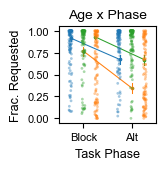

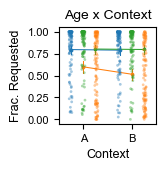

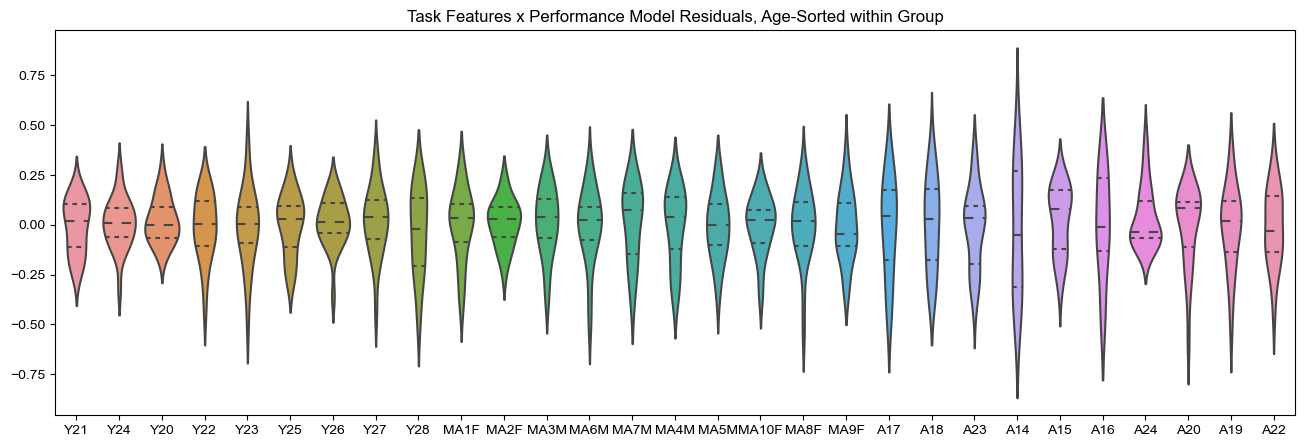

In [22]:
''' Task Feature LMM & Plot Extended Data Figure 1F '''

# Get new arrays breaking up sessions into epochs
sex = list(animalmeta.Sex[mice_ind])
blockrewardacenters = []
blocksexes = []
blockmice = []
blockseshcount = []
blockage = []
blockagem = []
contextID = []
blockorder = []
taskstruct = []

n = 4 # number of epochs per session

for m, session in zip(mice, sessions):
    center = rewarda_centers[np.where(mice == m)[0][0]]
    msex = sex[np.where(mice == m)[0][0]]
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    agem = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Month']) # represents age on last recording / sac day
    totalsesh = len(session)
    
    for i, s in enumerate(session):
        
        for j in range(n):
            blockrewardacenters = np.append(blockrewardacenters, center)
            blocksexes = np.append(blocksexes, msex)
            blockmice = np.append(blockmice, m)
            blockseshcount = np.append(blockseshcount, (i + 1))
            blockorder = np.append(blockorder, (j+1))
            
            if (j == 0) | (j == 2): 
                contextID = np.append(contextID, 'A')
            else:
                contextID = np.append(contextID, 'B')
                
            if (j == 0) | (j == 1): 
                taskstruct = np.append(taskstruct, 0)
            else:
                taskstruct = np.append(taskstruct, 1)
                
            blockage = np.append(blockage, age)
            
            if (i + 1) == len(session):
                realage = agem
            else:
                realage = agem - (totalsesh - (i + 1))*0.033 # approximates age on a given recording day
            blockagem = np.append(blockagem, realage)
            
# Collect all relevant data into pandas dataframe
Animal_ID = list(blockmice)
Session = list(blockseshcount)
Sex = list(blocksexes)
Age = list(blockagem)
Age_Group = list(blockage)
Reward_Order = list(blockrewardacenters)
Block_Order = list(blockorder)
Context_ID = list(contextID)
Satiety = list(blocksatiety)
ReqRate = list(blockreq)
TaskStruct = list(taskstruct)

tuples = list(zip(Animal_ID, Session, Sex, Age, Age_Group, Reward_Order, TaskStruct, Block_Order, Context_ID, Satiety, ReqRate))
tuples

blockdf = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'Sex', 'Age', 'AgeGroup','RewardOrder', 'TaskStruct', 'BlockOrder','ContextID','Satiety','ReqRate'])

'''
Model Construction Notes:
1. Fixed effects: age, sex, reward order, task struct (0 = block, 1 = alt), context ID (all categorical), session (continuous). 
2. Added context & taststruct to agegroup interaction terms.
3. Random effect is animal ID in that sessions are grouped by belonging to the same animal.
4. Modeling random intercepts & slopes captures learning rate differences that I'm hoping to model.

'''

# Get LMM & Print Results
mtask = smf.mixedlm('ReqRate ~ 1 + Session + Session:C(AgeGroup) + C(AgeGroup) + C(AgeGroup):C(Sex) + C(Sex) + C(RewardOrder) + Satiety + C(ContextID) + C(ContextID):C(AgeGroup) + C(TaskStruct) + C(TaskStruct):C(AgeGroup)', groups = 'AnimalID', re_formula = '~1 + Session', data=blockdf).fit(reml= True)
print(mtask.summary())
print(mtask.wald_test_terms(scalar = False))

#Plot Extended Data Fig 1f (left)
fig, ax = plt.subplots(figsize = (1.25,1.25))
g = sns.pointplot(data = blockdf, x = 'ContextID', y = 'ReqRate', hue= 'AgeGroup', ax = ax, dodge = 0.5, hue_order = hue_order, scale = 0.3)
sns.stripplot(data = blockdf, x = 'ContextID', y = 'ReqRate', hue= 'AgeGroup', ax = ax, s = 2, alpha = 0.4, dodge = True, palette = new_palette)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_xlabel('Context', fontsize = 9)
ax.set_title('Age x Context', fontsize = 10)
ax.set_yticks([0,0.25,0.5,0.75,1.0])
ax.tick_params(labelsize = 8)
#plt.legend(bbox_to_anchor = (1.02,1), fontsize = 9)
g.legend_.remove()
plt.setp(g.lines,linewidth = 0.75)
#fig.savefig(save_folder + 'contexteffect.png', dpi = 400, bbox_inches='tight')
#fig.savefig(save_folder + 'contexteffect.svg', dpi = 400, bbox_inches='tight')
plt.show()

#Plot Extended Data Fig 1f (right)
fig, ax = plt.subplots(figsize = (1.25,1.25))
g = sns.pointplot(data = blockdf, x = 'TaskStruct', y = 'ReqRate', hue= 'AgeGroup',ax = ax, dodge = 0.5, hue_order = hue_order, scale = 0.3)
sns.stripplot(data = blockdf, x = 'ContextID', y = 'ReqRate', hue= 'AgeGroup', s = 2, alpha = 0.4, ax = ax, dodge = True, palette = new_palette)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_xlabel('Task Phase', fontsize = 9)
ax.set_xticklabels(labels = ['Block','Alt'], fontsize = 9)
ax.set_title('Age x Phase', fontsize = 10)
ax.set_yticks([0,0.25,0.5,0.75,1.0])
ax.tick_params(labelsize = 8)
g.legend_.remove()
plt.setp(g.lines,linewidth = 0.75)
#fig.savefig(save_folder + 'taskstructeffect.png', dpi = 400, bbox_inches='tight')
#fig.savefig(save_folder + 'taskstructeffect.svg', dpi = 400, bbox_inches='tight')
plt.show()

#Plot task residuals
fig, ax = plt.subplots(figsize = (16,5))
blockdf['resid'] = mtask.resid
agesortID = blockmice[np.argsort(blockagem,kind='stable')]
mtaskresidsort = mtask.resid[np.argsort(blockagem,kind='stable')]
sns.violinplot(x = agesortID, y = mtaskresidsort, inner = 'quartile', ax = ax)
plt.title('Task Features x Performance Model Residuals, Age-Sorted within Group')
plt.show()

Model Results:
1. Model converges with REML. 
2. Context B negatively predicts performance. Context  (A vs. B) does not interact with age group to predict performance.
3. Alternation task structure (vs. context block) negatively predicts performance in general. Being aged interacts with this effect, further negatively predicting performance.

Residual Plot:
There is no systematic relationship between fractional age and magnitude of residuals as above.

To control for possible confounds of memory behavior differences, next, we more closely examined age group differences in running behavior in the SM task, visual acuity in the SM mice, and licking (reward-triggered, overall rate, error rate) behavior in the SM task.

In [24]:
''' Calculate Average, SEM, Peak Running Speed Across All Trials by Session & Animal '''
# Create lists for sessions
speed_avg = []
speed_sem = []
speed_max = []
session_speed = []

# Create lists for animals
speedavg = []
speedsem = []
speedmax = []

for m, session in zip(mice, sessions):
    
    mspeed = []
    
    for s in session:
        d = data[m][s]
        behaviorfil = d['behaviorfil']
        speed = behaviorfil[:,1]
        mspeed = np.append(mspeed,speed)
        
        # calculate mean, sem, peak speeds for each session
        avg_speed = np.mean(speed)
        sem_speed = stats.sem(speed)
        max_speed = np.amax(speed)
        
        # save mean, sem, peak speeds for each session
        speed_avg.append(avg_speed)
        speed_sem.append(sem_speed)
        speed_max.append(max_speed)   
    
    # calculate mean, sem, peak speeds for each animal
    avgspeed = np.mean(mspeed)
    semspeed = stats.sem(mspeed)
    maxspeed = np.amax(mspeed)
      
    # save mean, sem, peak speeds for each animal
    speedavg.append(avgspeed)
    speedsem.append(semspeed)
    speedmax.append(maxspeed)

#Session Stats    
speed_avg = np.asarray(speed_avg)
speed_sem = np.asarray(speed_sem)
speed_max = np.asarray(speed_max)

#Animal Stats
speedavg = np.asarray(speedavg)
speedsem = np.asarray(speedsem)
speedmax = np.asarray(speedmax)

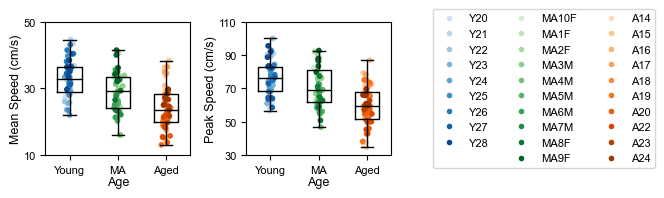

STATS:
mean speed_young ± SEM; mean speed_MA ± SEM; mean speed_old ± SEM
32.88 ± 0.73 ; 28.99 ± 0.76 ; 23.98 ± 0.86
F stat = 44.712372263711586
p_session = 1.9535823663201474e-10

peak speed_young ± SEM; peak speed_MA ± SEM; peak speed_old ± SEM
76.58 ± 1.47 ; 71.08 ± 1.59 ; 59.52 ± 1.62
F stat = 43.52851634707088
p_session = 3.5310410991681e-10


In [74]:
''' Plot Extended Data Figures 1B and 1H (legend) & Calculate Statistics'''

save_folder = 'C:/Users/Python/Desktop/LocalData/behaviorsm/' # adjust path

#get legend
handles = []
reqrate = [mreq_rates[y_ind],mreq_rates[ma_ind],mreq_rates[age_ind]]
for i in range(len(reqrate)):
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 3)
        handles.append(dot)
        
        if c[0] == col_animal[0][0][8][0]: # adds white space so columns are color sorted
            l = mlines.Line2D([0],[0],color="w")
            handles.append(l)

fig, ax = plt.subplots(1,2, figsize = (7,2))

speed_avg_tog = [speed_avg[y_sind],speed_avg[ma_sind],speed_avg[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5
ax[0].boxplot(speed_avg_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax[0].set_xlabel('Age', fontsize=9, labelpad=1)
ax[0].set_xticklabels(labels = labels, fontsize = 9)
ax[0].set_ylabel('Mean Speed (cm/s)', fontsize=9, labelpad=1)
ax[0].set_ylim([10, 50])
ax[0].set_yticks([10, 30, 50])
ax[0].tick_params(labelsize = 8)

for i in range(len(speed_avg_tog)):
    y = speed_avg_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    ax[0].scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 10)
    
speed_max_tog = [speed_max[y_sind],speed_max[ma_sind],speed_max[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5
ax[1].boxplot(speed_max_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))

ax[1].set_xlabel('Age', fontsize=9, labelpad=1)
ax[1].set_ylabel('Peak Speed (cm/s)', fontsize=9, labelpad=1)
ax[1].set_xticklabels(labels = labels, fontsize = 9)
ax[1].set_ylim([30, 110])
ax[1].set_yticks([30, 50, 70, 90, 110])
ax[1].tick_params(labelsize = 8)

for i in range(len(speed_max_tog)):
    y = speed_max_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    ax[1].scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 10)
    
ax[1].legend(handles = handles, labels = label_mice, ncol = 3, loc = 'center left', bbox_to_anchor = (1.25,0.5), fontsize = 8)
plt.tight_layout()
#plt.savefig(save_folder + 'speedprofile_session.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'speedprofile_session.svg', dpi=400, bbox_inches='tight')
plt.show()


print('STATS:')
print('mean speed_young ± SEM; mean speed_MA ± SEM; mean speed_old ± SEM')
print(str(np.round(np.mean(speed_avg[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(speed_avg[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(speed_avg[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(speed_avg[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(speed_avg[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(speed_avg[age_sind]), 2)))

stat, p_diff = stats.kruskal(speed_avg[y_sind],speed_avg[ma_sind],speed_avg[age_sind])
print('F stat = '+ str(stat))
print('p_session = ' + str(p_diff))

print('\npeak speed_young ± SEM; peak speed_MA ± SEM; peak speed_old ± SEM')
print(str(np.round(np.mean(speed_max[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(speed_max[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(speed_max[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(speed_max[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(speed_max[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(speed_max[age_sind]), 2)))

stat, p_diff = stats.kruskal(speed_max[y_sind],speed_max[ma_sind],speed_max[age_sind])
print('F stat = '+ str(stat))
print('p_session = ' + str(p_diff))


In [40]:
''' Load in Visual Acuity Raw .txt Files into Data Structure'''
mice = np.concatenate((cohortc_mice,cohortd_mice)) #note: cohort a lacked visual tests
print(mice)

#Create data dict
acuity_data = {}
for m in mice:
    acuity_data[m] = {}

#Save contrast & missed reward columns into it
for m in mice:

    d = acuity_data[m]
    mouse_contrasts = []
    mouse_missed = []

    with open('C:/Users/Python/Desktop/Dryad/visual_acuity/' + m + '_acuity.txt') as file:
        for line in file:
            mouse_contrasts = np.append(mouse_contrasts, float(line.split()[3]))
            mouse_missed = np.append(mouse_missed, int(line.split()[5]))
    
    d['mouse_contrasts'] = mouse_contrasts
    d['mouse_missed'] = mouse_missed
    
    print('N_Rewards: ' + str(len(mouse_contrasts)) + ' saved for mouse ' + m)
    
    file.close()

['A14' 'A15' 'A16' 'A17' 'A18' 'MA1F' 'MA2F' 'MA3M' 'MA4M' 'MA5M' 'MA6M'
 'MA7M' 'MA8F' 'MA9F' 'MA10F' 'Y20' 'Y21' 'Y22' 'Y23' 'Y24' 'A19' 'A20'
 'A22' 'A23' 'A24' 'Y25' 'Y26' 'Y27' 'Y28']
N_Rewards: 81 saved for mouse A14
N_Rewards: 135 saved for mouse A15
N_Rewards: 122 saved for mouse A16
N_Rewards: 126 saved for mouse A17
N_Rewards: 128 saved for mouse A18
N_Rewards: 125 saved for mouse MA1F
N_Rewards: 117 saved for mouse MA2F
N_Rewards: 124 saved for mouse MA3M
N_Rewards: 128 saved for mouse MA4M
N_Rewards: 115 saved for mouse MA5M
N_Rewards: 125 saved for mouse MA6M
N_Rewards: 104 saved for mouse MA7M
N_Rewards: 111 saved for mouse MA8F
N_Rewards: 132 saved for mouse MA9F
N_Rewards: 118 saved for mouse MA10F
N_Rewards: 101 saved for mouse Y20
N_Rewards: 108 saved for mouse Y21
N_Rewards: 137 saved for mouse Y22
N_Rewards: 234 saved for mouse Y23
N_Rewards: 135 saved for mouse Y24
N_Rewards: 114 saved for mouse A19
N_Rewards: 140 saved for mouse A20
N_Rewards: 134 saved for mouse 

In [51]:
''' Fit Psychometric Sigmoid Curves to each Mouse's Binned Visual Acuity Task Performance '''

bins = np.arange(0, 1.1, 0.1) # bin reward zone contrast values
par0 = np.array([0.1, 0.002]) # initialize sigmoid function

# define psychometric function
def pf(x, alpha, beta):
    return 1. / (1 + np.exp( -(x-alpha)/beta ))

centers = []
age_req = []
age_bins = []
MA_req = []
MA_bins = []
young_req = []
young_bins = []

for m in mice:
    d = acuity_data[m]
    contrasts = d['mouse_contrasts']
    missed = d['mouse_missed']
    bin_missed = []
    bin_requested = []

    digcontrast = np.digitize(contrasts, bins, right=True)
    bin_missed = [missed[digcontrast == i].mean() for i in range(0, len(bins))]
    bin_err = [stats.sem(missed[digcontrast == i]) for i in range(0, len(bins))]
    bin_requested = np.ones(len(bin_missed)) - bin_missed
    
    if m in SM_aged_mice:
        age_req.append(bin_requested)
        age_bins.append(bins)
    elif m in SM_MA_mice:
        MA_req.append(bin_requested)
        MA_bins.append(bins)
    else:
        young_req.append(bin_requested)
        young_bins.append(bins)
    
    par, mcov = curve_fit(pf, bins, bin_requested, par0, method = 'lm')
    print('Mouse ' + str(m) + ' Center: ' + str(par[0]) + ', Scale: ' + str(par[1]))
    centers = np.append(centers, par[0])
    
    '''
    Optional: plot individual mouse psychometric functions vs. binned data
    fig, ax = plt.subplots()
    
    if m in all_aged_mice:
        ax.errorbar(bins, bin_requested, yerr=bin_err, fmt='o', color = 'C1')
        ax.plot(bins, pf(bins, par[0], par[1]), color = 'C1')
    elif m in all_young_mice:
        ax.errorbar(bins, bin_requested, yerr=bin_err, fmt='o', color = 'C0')
        ax.plot(bins, pf(bins, par[0], par[1]), color = 'C0')
    else:
        ax.errorbar(bins, bin_requested, yerr=bin_err, fmt='o', color = 'C2')
        ax.plot(bins, pf(bins, par[0], par[1]), color = 'C2')
    
    plt.title(m + " Visual Acuity ")
    plt.xlabel("Binned Reward Zone Contrast")
    plt.ylabel("Fraction Requested")
    plt.yticks(np.arange(0,1.1,0.1))
    plt.legend(labels = ['fit: center = ' + str(np.round(par[0],4)) + ', scale = ' + str(np.round(par[1],4)),'mean requests ± sem',], loc = 'lower right')
    
    #plt.savefig(save_folder + 'visualacuity_' + m + '.svg', format = 'svg')
    #plt.savefig(save_folder + 'visualacuity_' + m + '.png', format = 'png')
    plt.show()
    ''' 
    
print('\nacuity thresh_young ± SEM; acuity thresh_MA ± SEM; acuity thresh_old ± SEM')
print(str(np.round(np.mean(centers[y_ind]), 4)) + ' ± ' + str(np.round(stats.sem(centers[y_ind]), 4)) + ' ; ' 
      + str(np.round(np.mean(centers[ma_ind]), 4)) + ' ± ' + str(np.round(stats.sem(centers[ma_ind]), 4)) + ' ; ' 
      + str(np.round(np.mean(centers[age_ind]), 4)) + ' ± ' + str(np.round(stats.sem(centers[age_ind]), 4)))

stat, p_diff = stats.kruskal(centers[y_ind],centers[ma_ind],centers[age_ind])
print('F stat = ' + str(stat))
print('p_animal = ' + str(p_diff))

Mouse A14 Center: 0.09561726899981103, Scale: 0.0001756599332359549
Mouse A15 Center: 0.09816741853625173, Scale: 0.002
Mouse A16 Center: 0.09918906978378586, Scale: 0.002
Mouse A17 Center: 0.0968888888777559, Scale: 0.001496128195905356
Mouse A18 Center: 0.09797949850667527, Scale: 0.0019973306370092846
Mouse MA1F Center: 0.1003646430906289, Scale: 0.002
Mouse MA2F Center: 0.09714285713263297, Scale: 0.00159460179585264
Mouse MA3M Center: 0.09561726899981103, Scale: 0.0001756599332359549
Mouse MA4M Center: 0.09561726899981103, Scale: 0.0001756599332359549
Mouse MA5M Center: 0.09780732178513561, Scale: 0.0019958617225256715
Mouse MA6M Center: 0.09561726899981103, Scale: 0.0001756599332359549
Mouse MA7M Center: 0.09816741853625173, Scale: 0.002
Mouse MA8F Center: 0.09861370564322418, Scale: 0.002
Mouse MA9F Center: 0.0968888888777559, Scale: 0.001496128195905356
Mouse MA10F Center: 0.09679999998854893, Scale: 0.0014563827631627112
Mouse Y20 Center: 0.10196165850602351, Scale: 0.002
Mous

Aged Center = 0.0763081389847334, Scale = 0.020822755249322412
MA Center = 0.07170073585823085, Scale = 0.017631222006301118
Young Center = 0.07621324427361109, Scale = 0.02340016950395055


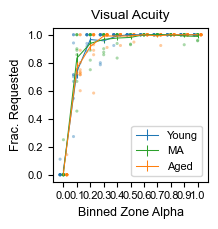

In [75]:
''' Plot Individual and Age Group Visual Acuity Data Together (Extended Data Figure 1d)'''

aged_mice = np.intersect1d(all_aged_mice, np.concatenate((cohortc_mice,cohortd_mice)))
young_mice =  np.intersect1d(all_young_mice, np.concatenate((cohortc_mice,cohortd_mice)))
MA_mice = np.intersect1d(all_MA_mice, np.concatenate((cohortc_mice,cohortd_mice)))

#Collect data
aged_contrasts = []
aged_missed = []
for m in aged_mice:
    d = acuity_data[m]
    
    contrasts = d['mouse_contrasts']
    missed = d['mouse_missed']
    
    aged_contrasts = np.append(aged_contrasts, contrasts)
    aged_missed = np.append(aged_missed, missed)
    
young_contrasts = []
young_missed = []
for m in young_mice:
    d = acuity_data[m]
    
    contrasts = d['mouse_contrasts']
    missed = d['mouse_missed']
    
    young_contrasts = np.append(young_contrasts, contrasts)
    young_missed = np.append(young_missed, missed)
    
MA_contrasts = []
MA_missed = []
for m in MA_mice:
    d = acuity_data[m]
    
    contrasts = d['mouse_contrasts']
    missed = d['mouse_missed']
    
    MA_contrasts = np.append(MA_contrasts, contrasts)
    MA_missed = np.append(MA_missed, missed)
    
#find bin contrasts
aged_digcontrast = np.digitize(aged_contrasts, bins, right = True)
MA_digcontrast = np.digitize(MA_contrasts, bins, right = True)
young_digcontrast = np.digitize(young_contrasts, bins, right = True)

#all data by age group by bin
allaged_bin_req = [1 - aged_missed[aged_digcontrast == i] for i in range(0, len(bins))]
allMA_bin_req = [1- MA_missed[MA_digcontrast == i] for i in range(0, len(bins))]
allyoung_bin_req = [1- young_missed[young_digcontrast == i] for i in range(0, len(bins))]

#means of bin by age group
aged_bin_missed = [aged_missed[aged_digcontrast == i].mean() for i in range(0, len(bins))]
aged_bin_err = [stats.sem(aged_missed[aged_digcontrast == i]) for i in range(0, len(bins))]
aged_bin_requested = np.ones(len(aged_bin_missed)) - aged_bin_missed
MA_bin_missed = [MA_missed[MA_digcontrast == i].mean() for i in range(0, len(bins))]
MA_bin_err = [stats.sem(MA_missed[MA_digcontrast == i]) for i in range(0, len(bins))]
MA_bin_requested = np.ones(len(MA_bin_missed)) - MA_bin_missed
young_bin_missed = [young_missed[young_digcontrast == i].mean() for i in range(0, len(bins))]
young_bin_err = [stats.sem(young_missed[young_digcontrast == i]) for i in range(0, len(bins))]
young_bin_requested = np.ones(len(young_bin_missed)) - young_bin_missed

#fit sigmoid functions to average age group data
par0 = np.array([0.1, 1])
aged_par, aged_mcov = curve_fit(pf, bins, aged_bin_requested, par0)
aged_perr = np.sqrt(np.diag(aged_mcov))
print('Aged Center = ' + str(aged_par[0]) + ', Scale = ' + str(aged_par[1]))

MA_par, MA_mcov = curve_fit(pf, bins, MA_bin_requested, par0)
MA_perr = np.sqrt(np.diag(MA_mcov))
print('MA Center = ' + str(MA_par[0]) + ', Scale = ' + str(MA_par[1]))

young_par, young_mcov = curve_fit(pf, bins, young_bin_requested, par0)
young_perr = np.sqrt(np.diag(young_mcov))
print('Young Center = ' + str(young_par[0]) + ', Scale = ' + str(young_par[1]))
    
# plot curves fit to average age group data + individual mouse data
fig, ax = plt.subplots(figsize = (2, 2))
ax.errorbar(bins, young_bin_requested, yerr = young_bin_err, linewidth = 0.75, color = 'C0', label = 'Young')
ax.errorbar(bins, MA_bin_requested, yerr = MA_bin_err, linewidth = 0.75, color = 'C2', label = 'MA')
ax.errorbar(bins, aged_bin_requested, yerr = aged_bin_err, linewidth = 0.75, color = 'C1',label = 'Aged')
ax.set_title("Visual Acuity", fontsize = 10)
ax.set_xlabel("Binned Zone Alpha", fontsize = 9)
ax.set_xticks(ticks = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
ax.set_ylabel("Frac. Requested", fontsize = 9)
ax.tick_params(labelsize = 8)
ax.legend(loc = 'lower right', fontsize = 8)

#scatter plot mouse actual data:
for i in range(0,len(young_req)):
    ax.scatter(young_bins[i] - 0.025, young_req[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

for i in range(0,len(MA_req)):
    ax.scatter(MA_bins[i], MA_req[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    
for i in range(0,len(age_req)):
    ax.scatter(age_bins[i] + 0.025, age_req[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    
#plt.savefig(save_folder + 'visualacuity_pooled' + '.svg', format = 'svg')
#plt.savefig(save_folder + 'visualacuity_pooled' + '.png', format = 'png')
plt.show()
    

There was no significant difference between acuity sigmoid curve centers across age groups. 

In [29]:
''' Calcuate Reward-Triggered Average Speed & Lick Plots for all SM Sessions for each Task Phase (Block vs. Alt)'''

mice , mice_ind, _  = np.intersect1d(all_mice, np.union1d(cohortc_mice, cohortd_mice), return_indices = True) # SM mice

sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])
    
brewardspeed = np.zeros((1,30)) 
arewardspeed = np.zeros((1,30)) 
brewardlick = np.zeros((1,30)) 
arewardlick = np.zeros((1,30)) 

save_folder = 'C:/Users/Python/Desktop/LocalData/behaviorsm/RTA/'

bloc_trough = []
btrough_prom = []
bloc_peak = []
bpeak_prom = []

aloc_trough = []
atrough_prom = []
aloc_peak = []
apeak_prom = []

from scipy.signal import peak_prominences as pp 

for m, session in zip(mice,sessions):
    for s in session:
        d = data[m][s]
        raw = d['raw']
        speed = raw.item().get('speed')
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        lick_ct = d['reward_data']['lick_ct']
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1)
        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1:
            dt = dt[dt != 0]
        
        # remove reward data pertaining to dark trials & skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            trial = raw.item().get('correctedtrial')
            
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0,np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
                
            skippedtrials = np.setdiff1d(alltrial,np.unique(trial))
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            
        except AttributeError:
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
            skippedtrials = []
        
        centers = np.array(reward['centers'][keep_idx])
        trials = np.array(reward['trials'][keep_idx])

        # find all reward trial's anticipatory lick ratios for a given session
        # get indices for anticipatory zone (25cm before reward zone) & reward zones (±25cm)
        start_idx = []
        end_idx = [] 
        
        for t, c in zip(trials, centers):
            trial_pos = posx.copy()
            start_trial_ind = np.where(trial == t)[0][0]
            t_posx = trial_pos[trial == t]

            zone_start = c - 50
            rzone_end = c + 25
            
            s_idx = np.argmin(np.abs(t_posx - zone_start)) 
            st_idx = np.argmin(np.abs(t_posx - zone_start)) + start_trial_ind
            re_idx = np.argmin(np.abs(t_posx[s_idx:] - rzone_end)) + st_idx
            
            start_idx.append(st_idx)
            end_idx.append(re_idx)
        
        start_idx = np.asarray(start_idx)
        end_idx = np.asarray(end_idx)

        # get running speed & lick counts pre- & in reward zones only
        in_zone_speed = []
        lick_ct_zone = []
        for i in range(start_idx.shape[0]):
            st = start_idx[i]
            e = end_idx[i] + 1
            in_zone_speed.append(speed[st:e])
            lick_ct_zone.append(lick_ct[st:e])

        #for each reward trial, get lick counts & speed binned by position peri-reward
        b = 2.5 # cm positions bins x 30 covering 75 cm (25 cm before + 50 cm reward zone)
        lick_ct_bin = np.zeros([trials.shape[0],30]) #number of bins per reward zone differs
        speed_bin = np.zeros([trials.shape[0],30])
        for i, t in enumerate(trials):
            st = start_idx[i]
            e = end_idx[i] + 1
            in_zone_posx = posx[st:e]

            edges = np.arange(posx[st], posx[e] + b, b)
            centers = (edges[:-1] + edges[1:])/2
            b_idx = np.digitize(posx[st:e], edges) # for every frame in zone, gives which bin it falls into 
            if np.min(b_idx) == 0 : # reassign last frames or so in order to get same number of bins 
                b_idx[b_idx == 0] = 1
            if np.max(b_idx) > 30: # reassign last frames or so in order to get same number of bins 
                b_idx[b_idx > 30] = 30
            unique_bdx = np.unique(b_idx)

            #average speed in each bin, find lick count / occupancy per bin
            for j in range(unique_bdx.shape[0]):
                idx1 = (b_idx == unique_bdx[j]) # boolean index of whether frames on this reward trial are in this bin

                if np.sum(idx1) == 0:
                    print('warning zero occupancy')
                    lick_ct_bin[i, j] = 0 
                    speed_bin[i, j] = 0
                else:    
                    occupancy = dt * np.sum(idx1)
                    lick_ct_bin[i, j] = np.sum(lick_ct_zone[i][idx1]) / occupancy
                    speed_bin[i, j] = np.mean(in_zone_speed[i][idx1])  

        # Get binned average speeds & licks around reward centers; save out speed troughs & lick peaks
        window = np.linspace(-25, 50, 30)
        bRTA_speed = np.mean(speed_bin[(trials < 140), :], axis=0)
        brewardspeed = np.r_[brewardspeed, speed_bin[trials < 140]]
        invbRTA_speed = 0 - bRTA_speed
        btroughspeed = np.where(bRTA_speed == np.min(bRTA_speed))[0]
        btroughprom = pp(invbRTA_speed, btroughspeed)[0]
        bloctrough = window[btroughspeed]
        
        aRTA_speed = np.mean(speed_bin[(trials >= 140),:], axis=0)
        arewardspeed = np.r_[arewardspeed, speed_bin[trials >= 140]]
        invaRTA_speed = 0 - aRTA_speed
        atroughspeed = np.where(aRTA_speed == np.min(aRTA_speed))[0]
        atroughprom = pp(invaRTA_speed, atroughspeed)[0]
        aloctrough = window[atroughspeed]
        
        bRTA_licks = np.mean(lick_ct_bin[(trials < 140), :], axis=0)
        brewardlick = np.r_[brewardlick, lick_ct_bin[trials < 140]]
        bpeaklicks = np.where(bRTA_licks == np.max(bRTA_licks))[0]
        bpeakprom = pp(bRTA_licks, bpeaklicks)[0]
        blocpeak = window[bpeaklicks]
        
        aRTA_licks = np.mean(lick_ct_bin[(trials >= 140), :], axis=0)
        arewardlick = np.r_[arewardlick, lick_ct_bin[trials >= 140]]
        apeaklicks = np.where(aRTA_licks == np.max(aRTA_licks))[0]
        apeakprom = pp(aRTA_licks, apeaklicks)[0]
        alocpeak = window[apeaklicks]   
        
        aloc_trough = np.append(aloc_trough,aloctrough)
        atrough_prom = np.append(atrough_prom,atroughprom)
        aloc_peak = np.append(aloc_peak,alocpeak)
        apeak_prom = np.append(apeak_prom,apeakprom)
        
        bloc_trough = np.append(bloc_trough,bloctrough)
        btrough_prom = np.append(btrough_prom,btroughprom)
        bloc_peak = np.append(bloc_peak,blocpeak)
        bpeak_prom = np.append(bpeak_prom,bpeakprom)

        '''
        Optional: visualize reward-triggered licking and slowing by session 
        
        # define plotting plot size & title
        fig, (ax1,ax2) = plt.subplots(1, 2, sharex = True, figsize = (4,2))
        fig.tight_layout()
        fig.suptitle(('Block RTA Speed & Licks: ' + m + '_' + s), fontsize = 10)

        # plot speeds in reward zone and average
        for i in range(speed_bin[(trials < 140), :].shape[0]):
            ax1.plot(window, speed_bin[i, :], '-k', linewidth=0.5, alpha=0.1)
        ax1.plot(window, bRTA_speed, '-k', linewidth=1.5, alpha=1)

        # plot reward location
        y_lims = ax1.get_ylim()
        ax1.plot([0, 0], y_lims, '--k', linewidth=0.75)

        # format axes
        ax1.set_xlim([-25, 50])
        ax1.set_xticks([-25, 0, 50])
        ax1.set_ylabel('speed (cm / s)')

        # plot licks in reward zone and average
        for i in range(lick_ct_bin[(trials < 140), :].shape[0]):
            ax2.plot(window, lick_ct_bin[i, :], '-k', linewidth=0.5, alpha=0.1)
        ax2.plot(window, bRTA_licks, '-', color='black', linewidth=1.5, alpha=1)

        # plot reward location
        y_lims = ax2.get_ylim()
        ax2.plot([0,0], y_lims, '--k', linewidth=0.75)

        # format axes
        ax2.set_xlim([-25, 50])
        ax2.set_xticks([-25, 0, 50])
        ax2.set_ylabel('licks / bin')

        fig.supxlabel('cm from reward start', fontsize = 10)
        fig.savefig(save_folder + m + '_' + str(s) + '_RTAsession_blockbinspeedlick.png', dpi=400, bbox_inches='tight')
        fig.savefig(save_folder + m + '_' + str(s) + '_RTAsession_blockbinspeedlick.svg', dpi=400, bbox_inches='tight')
        plt.show()
        
        # define plotting plot size & title
        fig, (ax1,ax2) = plt.subplots(1, 2, sharex = True, figsize = (4,2))
        fig.tight_layout()
        fig.suptitle(('Altneration RTA Speed & Licks: ' + m + '_' + s), fontsize = 10)

        # plot speeds in reward zone and average
        for i in range(speed_bin[trials >= 140].shape[0]):
            j = speed_bin[(trials < 140), :].shape[0]
            ax1.plot(window, speed_bin[i + j, :], '-k', linewidth=0.5, alpha=0.1)
        ax1.plot(window, aRTA_speed, '-k', linewidth=1.5, alpha=1)

        # plot reward location
        y_lims = ax1.get_ylim()
        ax1.plot([0, 0], y_lims, '--k', linewidth=0.75)

        # format axes
        ax1.set_xlim([-25, 50])
        ax1.set_xticks([-25, 0, 50])
        ax1.set_ylabel('speed (cm / s)')

        # plot licks in reward zone and average
        for i in range(lick_ct_bin[trials >= 140].shape[0]):
            #print(lick_ct_bin[trials >= 140].shape[0])
            j = lick_ct_bin[(trials < 140), :].shape[0]
            ax2.plot(window, lick_ct_bin[i + j, :], '-k', linewidth=0.5, alpha=0.1)
        ax2.plot(window, aRTA_licks, '-', color='black', linewidth=1.5, alpha=1)

        # plot reward location
        y_lims = ax2.get_ylim()
        ax2.plot([0,0], y_lims, '--k', linewidth=0.75)

        # format axes
        ax2.set_xlim([-25, 50])
        ax2.set_xticks([-25, 0, 50])
        ax2.set_ylabel('licks / bin')

        fig.supxlabel('cm from reward start', fontsize = 10)
        fig.savefig(save_folder + m + '_' + str(s) + '_RTAsession_altbinspeedlick.png', dpi=400, bbox_inches='tight')
        fig.savefig(save_folder + m + '_' + str(s) + '_RTAsession_altbinspeedlick.svg', dpi=400, bbox_inches='tight')
        plt.show()
        
        '''

C:\Users\Python\AppData\Local\Temp\ipykernel_12568\1233577638.py:135: PeakPropertyWarning: some peaks have a prominence of 0
  atroughprom = pp(invaRTA_speed, atroughspeed)[0]
C:\Users\Python\AppData\Local\Temp\ipykernel_12568\1233577638.py:128: PeakPropertyWarning: some peaks have a prominence of 0
  btroughprom = pp(invbRTA_speed, btroughspeed)[0]


In [30]:
'''Store Session 1 - 6 for Block Reward-Triggered Behavior in Nested Lists'''
r = 6
bloctrough_aged = [[] * r for i in range(r)]
btroughprom_aged= [[] * r for i in range(r)]
blocpeak_aged = [[] * r for i in range(r)]
bpeakprom_aged = [[] * r for i in range(r)]

bloctrough_MA = [[] * r for i in range(r)]
btroughprom_MA = [[] * r for i in range(r)]
blocpeak_MA = [[] * r for i in range(r)]
bpeakprom_MA = [[] * r for i in range(r)]

bloctrough_young = [[] * r for i in range(r)]
btroughprom_young= [[] * r for i in range(r)]
blocpeak_young = [[] * r for i in range(r)]
bpeakprom_young = [[] * r for i in range(r)]

bsessioncount_young = [[] * r for i in range(r)]
bsessioncount_MA = [[] * r for i in range(r)]
bsessioncount_aged = [[] * r for i in range(r)]

count = 0
for m, session in zip(mice, sessions): 
    
    session_idx = np.arange(0 + count, len(session) + count)
    count += len(session)
    
    if m in SM_aged_mice:
        for s in range(0, len(session_idx)):
            bloctrough_aged[s] = np.append(bloctrough_aged[s],bloc_trough[session_idx][s])
            btroughprom_aged[s] = np.append(btroughprom_aged[s],btrough_prom[session_idx][s])
            blocpeak_aged[s] = np.append(blocpeak_aged[s],bloc_peak[session_idx][s])
            bpeakprom_aged[s] = np.append(bpeakprom_aged[s],bpeak_prom[session_idx][s])
            bsessioncount_aged[s] = np.append(bsessioncount_aged[s], s + 1)
    elif m in SM_MA_mice:
        for s in range(0, len(session_idx)):
            bloctrough_MA[s] = np.append(bloctrough_MA[s],bloc_trough[session_idx][s])
            btroughprom_MA[s] = np.append(btroughprom_MA[s],btrough_prom[session_idx][s])
            blocpeak_MA[s] = np.append(blocpeak_MA[s],bloc_peak[session_idx][s])
            bpeakprom_MA[s] = np.append(bpeakprom_MA[s],bpeak_prom[session_idx][s])
            bsessioncount_MA[s] = np.append(bsessioncount_MA[s], s + 1)
    else:
        for s in range(0, len(session_idx)):
            bloctrough_young[s] = np.append(bloctrough_young[s],bloc_trough[session_idx][s])
            btroughprom_young[s] = np.append(btroughprom_young[s],btrough_prom[session_idx][s])
            blocpeak_young[s] = np.append(blocpeak_young[s],bloc_peak[session_idx][s])
            bpeakprom_young[s] = np.append(bpeakprom_young[s],bpeak_prom[session_idx][s])
            bsessioncount_young[s] = np.append(bsessioncount_young[s], s + 1)
            
#find means & SEM for each age group 
bloctrough_meanaged = []
bloctrough_erraged = []
btroughprom_meanaged = []
btroughprom_erraged = []
blocpeak_meanaged = []
blocpeak_erraged = []
bpeakprom_meanaged = []
bpeakprom_erraged = []

for i in range(0,len(bloctrough_aged)):
    bloctrough_meanaged = np.append(bloctrough_meanaged,np.mean(bloctrough_aged[i]))
    bloctrough_erraged = np.append(bloctrough_erraged,stats.sem(bloctrough_aged[i]))
    
    btroughprom_meanaged = np.append(btroughprom_meanaged,np.mean(btroughprom_aged[i]))
    btroughprom_erraged = np.append(btroughprom_erraged,stats.sem(btroughprom_aged[i]))
    
    blocpeak_meanaged = np.append(blocpeak_meanaged,np.mean(blocpeak_aged[i]))
    blocpeak_erraged = np.append(blocpeak_erraged,stats.sem(blocpeak_aged[i]))
    
    bpeakprom_meanaged = np.append(bpeakprom_meanaged,np.mean(bpeakprom_aged[i]))
    bpeakprom_erraged = np.append(bpeakprom_erraged,stats.sem(bpeakprom_aged[i]))
    
bloctrough_meanMA = []
bloctrough_errMA = []
btroughprom_meanMA = []
btroughprom_errMA = []
blocpeak_meanMA = []
blocpeak_errMA = []
bpeakprom_meanMA = []
bpeakprom_errMA = []

for i in range(0,len(bloctrough_MA)):
    bloctrough_meanMA = np.append(bloctrough_meanMA,np.mean(bloctrough_MA[i]))
    bloctrough_errMA = np.append(bloctrough_errMA,stats.sem(bloctrough_MA[i]))
    
    btroughprom_meanMA = np.append(btroughprom_meanMA,np.mean(btroughprom_MA[i]))
    btroughprom_errMA = np.append(btroughprom_errMA,stats.sem(btroughprom_MA[i]))
    
    blocpeak_meanMA = np.append(blocpeak_meanMA,np.mean(blocpeak_MA[i]))
    blocpeak_errMA = np.append(blocpeak_errMA,stats.sem(blocpeak_MA[i]))
    
    bpeakprom_meanMA = np.append(bpeakprom_meanMA,np.mean(bpeakprom_MA[i]))
    bpeakprom_errMA = np.append(bpeakprom_errMA,stats.sem(bpeakprom_MA[i]))
    
bloctrough_meanyoung = []
bloctrough_erryoung = []
btroughprom_meanyoung = []
btroughprom_erryoung = []
blocpeak_meanyoung = []
blocpeak_erryoung = []
bpeakprom_meanyoung = []
bpeakprom_erryoung= []

for i in range(0,len(bloctrough_young)):
    bloctrough_meanyoung = np.append(bloctrough_meanyoung,np.mean(bloctrough_young[i]))
    bloctrough_erryoung = np.append(bloctrough_erryoung,stats.sem(bloctrough_young[i]))
    
    btroughprom_meanyoung = np.append(btroughprom_meanyoung,np.mean(btroughprom_young[i]))
    btroughprom_erryoung = np.append(btroughprom_erryoung,stats.sem(btroughprom_young[i]))
    
    blocpeak_meanyoung = np.append(blocpeak_meanyoung,np.mean(blocpeak_young[i]))
    blocpeak_erryoung = np.append(blocpeak_erryoung,stats.sem(blocpeak_young[i]))
    
    bpeakprom_meanyoung = np.append(bpeakprom_meanyoung,np.mean(bpeakprom_young[i]))
    bpeakprom_erryoung = np.append(bpeakprom_erryoung,stats.sem(bpeakprom_young[i]))

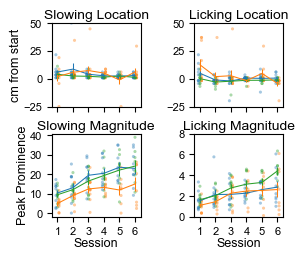

In [31]:
''' Plot Avg. Block Reward-Triggered Behavior over Days by Age Group (Extended Data Figure 1e [left])'''

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (3,2.5), sharex = True)
fig.tight_layout()

ax1.errorbar(np.arange(1,7,1),bloctrough_meanyoung,yerr = bloctrough_erryoung, label = 'Young Average', linewidth = 0.75)
ax1.errorbar(np.arange(1,7,1),bloctrough_meanMA,yerr = bloctrough_errMA, label = 'MA Average', color = 'C2', linewidth = 0.75)
ax1.errorbar(np.arange(1,7,1),bloctrough_meanaged,yerr = bloctrough_erraged, label = 'Aged Average', color = 'C1', linewidth = 0.75)
ax1.set_title('Slowing Location', fontsize=10, pad=3)
ax1.set_ylim((-25,50))
ax1.set_yticks((-25,0,25,50))
ax1.tick_params(labelsize = 8)
ax1.set_ylabel('cm from start', fontsize = 9, labelpad=1)

ax2.errorbar(np.arange(1,7,1),blocpeak_meanyoung,yerr = blocpeak_erryoung, label = 'Young', color = 'C0', linewidth = 0.75)
ax2.errorbar(np.arange(1,7,1),blocpeak_meanMA,yerr = blocpeak_errMA, label = 'MA', color = 'C2', linewidth = 0.75)
ax2.errorbar(np.arange(1,7,1),blocpeak_meanaged,yerr = blocpeak_erraged, label = 'Aged', color = 'C1', linewidth = 0.75)
ax2.set_title('Licking Location', fontsize=10, pad=3)
ax2.set_ylim((-25,50))
ax2.set_yticks((-25,0,25,50))
ax2.tick_params(labelsize = 8)
#ax2.set_ylabel('Distance from Reward Zone Start (cm)', fontsize=12, labelpad=2)

ax3.errorbar(np.arange(1,7,1),btroughprom_meanyoung, yerr = btroughprom_erryoung, label = 'Young Average', linewidth = 0.75)
ax3.errorbar(np.arange(1,7,1),btroughprom_meanMA,yerr = btroughprom_errMA, label = 'MA Average', color = 'C2', linewidth = 0.75)
ax3.errorbar(np.arange(1,7,1),btroughprom_meanaged, yerr = btroughprom_erraged, label = 'Aged Average', color = 'C1', linewidth = 0.75)
ax3.set_title('Slowing Magnitude', fontsize=10, pad=3)
ax3.set_xlabel('Session', fontsize=9, labelpad=1)
#ax3.set_ylim((0,40))
ax3.set_yticks((0,10,20,30,40))
ax3.set_ylabel('Peak Prominence', fontsize=9, labelpad=1)
ax3.tick_params(labelsize = 8)

ax4.errorbar(np.arange(1,7,1),bpeakprom_meanyoung, yerr = bpeakprom_erryoung, label = 'Young Average', linewidth = 0.75)
ax4.errorbar(np.arange(1,7,1),bpeakprom_meanMA,yerr = bpeakprom_errMA, label = 'MA Average', color = 'C2', linewidth = 0.75)
ax4.errorbar(np.arange(1,7,1),bpeakprom_meanaged, yerr = bpeakprom_erraged, label = 'Aged Average', color = 'C1', linewidth = 0.75)
ax4.set_title('Licking Magnitude', fontsize=10, pad=3)
ax4.set_xlabel('Session', fontsize=9, labelpad=1)
ax4.set_ylim((0,8))
#ax4.set_ylabel('Peak Prom. (licks)', fontsize=9, labelpad=1)
ax4.set_xticks([1,2,3,4,5,6])
ax4.set_yticks((0,2,4,6,8))
#ax4.legend(bbox_to_anchor = (1.2,1),fontsize = 9)
#ax4.set_ylabel('Peak Prom. (licks)', fontsize=9, labelpad=1)
ax4.tick_params(labelsize = 8)

#scatter plot actual data:
for i in range(0,len(bloctrough_aged)):
    ax1.scatter(bsessioncount_aged[i] + 0.1, bloctrough_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax1.scatter(bsessioncount_MA[i], bloctrough_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax1.scatter(bsessioncount_young[i] - 0.1, bloctrough_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax2.scatter(bsessioncount_aged[i] + 0.1, blocpeak_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax2.scatter(bsessioncount_MA[i], blocpeak_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax2.scatter(bsessioncount_young[i] - 0.1, blocpeak_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax3.scatter(bsessioncount_aged[i] + 0.1, btroughprom_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax3.scatter(bsessioncount_MA[i], btroughprom_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax3.scatter(bsessioncount_young[i] - 0.1, btroughprom_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

    ax4.scatter(bsessioncount_aged[i] + 0.1, bpeakprom_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax4.scatter(bsessioncount_MA[i], bpeakprom_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax4.scatter(bsessioncount_young[i] - 0.1, bpeakprom_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#plt.savefig(save_folder + 'time_blockRTAslowinglicking_avganimal.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'time_blockRTAslowinglicking_avganimal.svg', dpi=400, bbox_inches='tight')
plt.show()

                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       Loctrough
No. Observations:        163           Method:                   REML     
No. Groups:              29            Scale:                    46.6312  
Min. group size:         3             Log-Likelihood:           -540.4325
Max. group size:         6             Converged:                Yes      
Mean group size:         5.6                                              
--------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------
Intercept                       7.931    2.658  2.984 0.003   2.722 13.140
C(AgeGroup)[T.2.0]             -3.478    3.778 -0.920 0.357 -10.883  3.928
C(AgeGroup)[T.3.0]             -3.190    3.721 -0.857 0.391 -10.483  4.103
C(Sex)[T.M]                     0.216    2.7

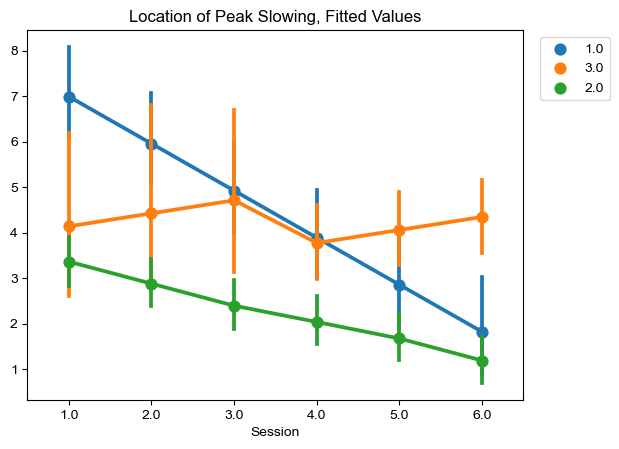

                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       Locpeak  
No. Observations:         163           Method:                   REML     
No. Groups:               29            Scale:                    38.3115  
Min. group size:          3             Log-Likelihood:           -537.3078
Max. group size:          6             Converged:                Yes      
Mean group size:          5.6                                              
---------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        0.690    3.355  0.206 0.837  -5.886  7.265
C(AgeGroup)[T.2.0]              -3.100    4.763 -0.651 0.515 -12.436  6.235
C(AgeGroup)[T.3.0]              13.964    4.720  2.958 0.003   4.712 23.215
C(Sex)[T.M]                    

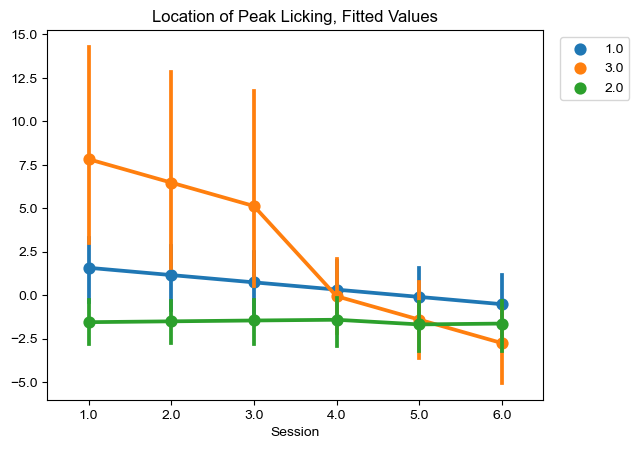

                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Troughprom
No. Observations:       163           Method:                   REML      
No. Groups:             29            Scale:                    28.4001   
Min. group size:        3             Log-Likelihood:           -512.2501 
Max. group size:        6             Converged:                Yes       
Mean group size:        5.6                                               
--------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------
Intercept                       8.656    2.710  3.194 0.001   3.345 13.968
C(AgeGroup)[T.2.0]             -2.744    3.849 -0.713 0.476 -10.288  4.801
C(AgeGroup)[T.3.0]             -2.871    3.810 -0.753 0.451 -10.338  4.597
C(Sex)[T.M]                     0.077    3.3

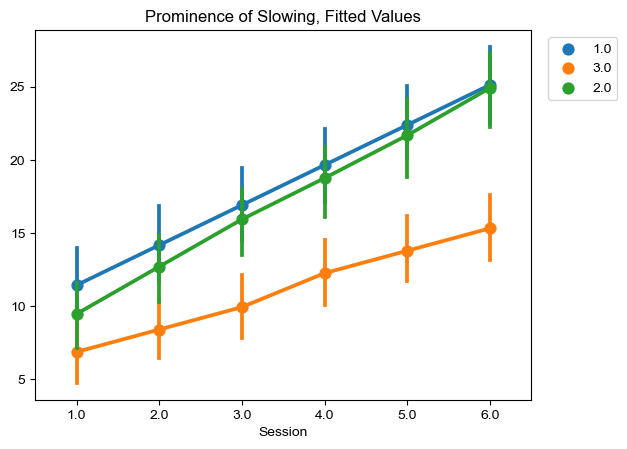

                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Peakprom 
No. Observations:       163           Method:                   REML     
No. Groups:             29            Scale:                    0.9352   
Min. group size:        3             Log-Likelihood:           -245.4219
Max. group size:        6             Converged:                Yes      
Mean group size:        5.6                                              
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       1.520    0.437  3.476 0.001  0.663  2.377
C(AgeGroup)[T.2.0]             -0.455    0.621 -0.732 0.464 -1.672  0.763
C(AgeGroup)[T.3.0]             -0.545    0.614 -0.888 0.375 -1.748  0.658
C(Sex)[T.M]                    -0.145    0.516 -0.280 0.

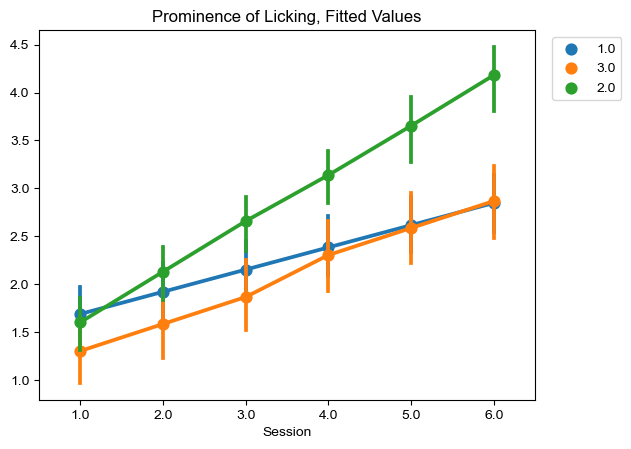

In [35]:
''' Runn LMM on Block Reward-Triggered Behavior '''
Animal_ID = list(seshmice)
Session = list(seshcount)
Sex = list(sexes)
Age_Group = list(seshage)

Loctrough = list(bloc_trough) #slowing
Locpeak = list(bloc_peak) # licking
Troughprom = list(btrough_prom)
Peakprom = list(bpeak_prom)

tuples = list(zip(Animal_ID, Session, Sex, Age_Group, Loctrough, Locpeak, Troughprom, Peakprom))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'Sex', 'AgeGroup','Loctrough', 'Locpeak', 'Troughprom', 'Peakprom'])

hue_order = [1.0,3.0,2.0]
mtotal = smf.mixedlm('Loctrough ~ 1 + C(AgeGroup) + Session:C(AgeGroup) + C(Sex) + C(Sex):C(AgeGroup) + Session', groups = 'AnimalID', re_formula = '~1', data=df).fit(reml= True)
print(mtotal.summary())
print(mtotal.wald_test_terms(scalar = False))

sns.pointplot(x = df['Session'], y = mtotal.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('Location of Peak Slowing, Fitted Values')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

mtotal = smf.mixedlm('Locpeak ~ 1 + C(AgeGroup) + Session:C(AgeGroup) + C(Sex) + C(Sex):C(AgeGroup) + Session', groups = 'AnimalID', re_formula = '~1', data=df).fit(reml= True)
print(mtotal.summary())
print(mtotal.wald_test_terms(scalar = False))

sns.pointplot(x = df['Session'], y = mtotal.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('Location of Peak Licking, Fitted Values')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

mtotal = smf.mixedlm('Troughprom ~ 1 + C(AgeGroup) + Session:C(AgeGroup) + C(Sex) + C(Sex):C(AgeGroup) + Session', groups = 'AnimalID', re_formula = '~1', data=df).fit(reml= True)
print(mtotal.summary())
print(mtotal.wald_test_terms(scalar = False))

sns.pointplot(x = df['Session'], y = mtotal.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('Prominence of Slowing, Fitted Values')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

mtotal = smf.mixedlm('Peakprom ~ 1 + C(AgeGroup) + Session:C(AgeGroup) + C(Sex) + C(Sex):C(AgeGroup) + Session', groups = 'AnimalID', re_formula = '~1', data=df).fit(reml= True)
print(mtotal.summary())
print(mtotal.wald_test_terms(scalar = False))

sns.pointplot(x = df['Session'], y = mtotal.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('Prominence of Licking, Fitted Values')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

Block Behavior Model Results:
1. All models converge with REML.
2. In general, reward-triggered slowing and licking behavior in the block phase does not differ by age group or in the interaction of age group with session. 
3. The exceptions are that age predicted later maximal licking location relative to the reward zone start and the age interacted with session to predict smaller changes in slowing  magnitude over days. 

In [36]:
'''Store Session 1 - 6 for Alternation Reward-Triggered Behavior in Nested Lists'''
r = 6
aloctrough_aged = [[] * r for i in range(r)]
atroughprom_aged= [[] * r for i in range(r)]
alocpeak_aged = [[] * r for i in range(r)]
apeakprom_aged = [[] * r for i in range(r)]

aloctrough_MA = [[] * r for i in range(r)]
atroughprom_MA = [[] * r for i in range(r)]
alocpeak_MA = [[] * r for i in range(r)]
apeakprom_MA = [[] * r for i in range(r)]

aloctrough_young = [[] * r for i in range(r)]
atroughprom_young= [[] * r for i in range(r)]
alocpeak_young = [[] * r for i in range(r)]
apeakprom_young = [[] * r for i in range(r)]

asessioncount_young = [[] * r for i in range(r)]
asessioncount_MA = [[] * r for i in range(r)]
asessioncount_aged = [[] * r for i in range(r)]

count = 0
for m, session in zip(mice, sessions): 
    
    session_idx = np.arange(0 + count, len(session) + count)
    count += len(session)
    
    if m in SM_aged_mice:
        for s in range(0, len(session_idx)):
            aloctrough_aged[s] = np.append(aloctrough_aged[s],aloc_trough[session_idx][s])
            atroughprom_aged[s] = np.append(atroughprom_aged[s],atrough_prom[session_idx][s])
            alocpeak_aged[s] = np.append(alocpeak_aged[s],aloc_peak[session_idx][s])
            apeakprom_aged[s] = np.append(apeakprom_aged[s],apeak_prom[session_idx][s])
            asessioncount_aged[s] = np.append(asessioncount_aged[s], s + 1)
            
    elif m in SM_MA_mice:
        for s in range(0, len(session_idx)):
            aloctrough_MA[s] = np.append(aloctrough_MA[s],aloc_trough[session_idx][s])
            atroughprom_MA[s] = np.append(atroughprom_MA[s],atrough_prom[session_idx][s])
            alocpeak_MA[s] = np.append(alocpeak_MA[s],aloc_peak[session_idx][s])
            apeakprom_MA[s] = np.append(apeakprom_MA[s],apeak_prom[session_idx][s])
            asessioncount_MA[s] = np.append(asessioncount_MA[s], s + 1)
    else:
        for s in range(0, len(session_idx)):
            aloctrough_young[s] = np.append(aloctrough_young[s],aloc_trough[session_idx][s])
            atroughprom_young[s] = np.append(atroughprom_young[s],atrough_prom[session_idx][s])
            alocpeak_young[s] = np.append(alocpeak_young[s],aloc_peak[session_idx][s])
            apeakprom_young[s] = np.append(apeakprom_young[s],apeak_prom[session_idx][s])
            asessioncount_young[s] = np.append(asessioncount_young[s], s + 1)

#find means & SEM for each age group 
aloctrough_meanaged = []
aloctrough_erraged = []
atroughprom_meanaged = []
atroughprom_erraged = []
alocpeak_meanaged = []
alocpeak_erraged = []
apeakprom_meanaged = []
apeakprom_erraged = []

for i in range(0,len(aloctrough_aged)):
    aloctrough_meanaged = np.append(aloctrough_meanaged,np.mean(aloctrough_aged[i]))
    aloctrough_erraged = np.append(aloctrough_erraged,stats.sem(aloctrough_aged[i]))
    
    atroughprom_meanaged = np.append(atroughprom_meanaged,np.mean(atroughprom_aged[i]))
    atroughprom_erraged = np.append(atroughprom_erraged,stats.sem(atroughprom_aged[i]))
    
    alocpeak_meanaged = np.append(alocpeak_meanaged,np.mean(alocpeak_aged[i]))
    alocpeak_erraged = np.append(alocpeak_erraged,stats.sem(alocpeak_aged[i]))
    
    apeakprom_meanaged = np.append(apeakprom_meanaged,np.mean(apeakprom_aged[i]))
    apeakprom_erraged = np.append(apeakprom_erraged,stats.sem(apeakprom_aged[i]))
    
aloctrough_meanMA = []
aloctrough_errMA = []
atroughprom_meanMA = []
atroughprom_errMA = []
alocpeak_meanMA = []
alocpeak_errMA = []
apeakprom_meanMA = []
apeakprom_errMA = []

for i in range(0,len(aloctrough_MA)):
    aloctrough_meanMA = np.append(aloctrough_meanMA,np.mean(aloctrough_MA[i]))
    aloctrough_errMA = np.append(aloctrough_errMA,stats.sem(aloctrough_MA[i]))
    
    atroughprom_meanMA = np.append(atroughprom_meanMA,np.mean(atroughprom_MA[i]))
    atroughprom_errMA = np.append(atroughprom_errMA,stats.sem(atroughprom_MA[i]))
    
    alocpeak_meanMA = np.append(alocpeak_meanMA,np.mean(alocpeak_MA[i]))
    alocpeak_errMA = np.append(alocpeak_errMA,stats.sem(alocpeak_MA[i]))
    
    apeakprom_meanMA = np.append(apeakprom_meanMA,np.mean(apeakprom_MA[i]))
    apeakprom_errMA = np.append(apeakprom_errMA,stats.sem(apeakprom_MA[i]))
    
aloctrough_meanyoung = []
aloctrough_erryoung = []
atroughprom_meanyoung = []
atroughprom_erryoung = []
alocpeak_meanyoung = []
alocpeak_erryoung = []
apeakprom_meanyoung = []
apeakprom_erryoung= []

for i in range(0,len(aloctrough_young)):
    aloctrough_meanyoung = np.append(aloctrough_meanyoung,np.mean(aloctrough_young[i]))
    aloctrough_erryoung = np.append(aloctrough_erryoung,stats.sem(aloctrough_young[i]))
    
    atroughprom_meanyoung = np.append(atroughprom_meanyoung,np.mean(atroughprom_young[i]))
    atroughprom_erryoung = np.append(atroughprom_erryoung,stats.sem(atroughprom_young[i]))
    
    alocpeak_meanyoung = np.append(alocpeak_meanyoung,np.mean(alocpeak_young[i]))
    alocpeak_erryoung = np.append(alocpeak_erryoung,stats.sem(alocpeak_young[i]))
    
    apeakprom_meanyoung = np.append(apeakprom_meanyoung,np.mean(apeakprom_young[i]))
    apeakprom_erryoung = np.append(apeakprom_erryoung,stats.sem(apeakprom_young[i]))

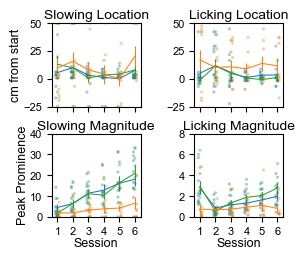

In [37]:
''' Plot Avg. Alternation Reward-Triggered Behavior over Days by Age Group (Extended Data Figure 1e [right])'''

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (3,2.5), sharex = True)
fig.tight_layout()

ax1.errorbar(np.arange(1,7,1),aloctrough_meanyoung,yerr = aloctrough_erryoung, label = 'Young Average', color = 'C0', linewidth = 0.75)
ax1.errorbar(np.arange(1,7,1),aloctrough_meanMA,yerr = aloctrough_errMA, label = 'MA Average', color = 'C2', linewidth = 0.75)
ax1.errorbar(np.arange(1,7,1),aloctrough_meanaged,yerr = aloctrough_erraged, label = 'Aged Average', color = 'C1', linewidth = 0.75)
ax1.set_title('Slowing Location', fontsize=10, pad=3)
ax1.set_ylim((-25,50))
ax1.set_yticks((-25,0,25,50))
ax1.tick_params(labelsize = 8)
ax1.set_ylabel('cm from start', fontsize = 9, labelpad=1)

ax2.errorbar(np.arange(1,7,1),alocpeak_meanyoung,yerr = alocpeak_erryoung, label = 'Young', color = 'C0', linewidth = 0.75)
ax2.errorbar(np.arange(1,7,1),alocpeak_meanMA,yerr = alocpeak_errMA, label = 'MA', color = 'C2', linewidth = 0.75)
ax2.errorbar(np.arange(1,7,1),alocpeak_meanaged,yerr = alocpeak_erraged, label = 'Aged', color = 'C1', linewidth = 0.75)
ax2.set_title('Licking Location', fontsize=10, pad=3)
ax2.set_ylim((-25,50))
ax2.set_yticks((-25,0,25,50))
ax2.tick_params(labelsize = 8)
#ax2.legend(bbox_to_anchor = (1.2,1), fontsize = 9)
#ax2.set_ylabel('Distance from Reward Zone Start (cm)', fontsize=12, labelpad=2)

ax3.errorbar(np.arange(1,7,1),atroughprom_meanyoung, yerr = atroughprom_erryoung, label = 'Young Average', color = 'C0', linewidth = 0.75)
ax3.errorbar(np.arange(1,7,1),atroughprom_meanMA,yerr = atroughprom_errMA, label = 'MA Average', color = 'C2', linewidth = 0.75)
ax3.errorbar(np.arange(1,7,1),atroughprom_meanaged, yerr = atroughprom_erraged, label = 'Aged Average', color = 'C1', linewidth = 0.75)
ax3.set_title('Slowing Magnitude', fontsize=10, pad=3)
ax3.set_xlabel('Session', fontsize=9, labelpad=1)
ax3.set_ylim((0,35))
#ax3.set_ylim((0,40))
ax3.set_yticks((0, 10, 20, 30, 40))
ax3.set_ylabel('Peak Prominence', fontsize=9, labelpad=1)
ax3.tick_params(labelsize = 8)

ax4.errorbar(np.arange(1,7,1),apeakprom_meanyoung, yerr = apeakprom_erryoung, label = 'Young Average' , color = 'C0', linewidth = 0.75)
ax4.errorbar(np.arange(1,7,1),apeakprom_meanMA,yerr = apeakprom_errMA, label = 'MA Average', color = 'C2', linewidth = 0.75)
ax4.errorbar(np.arange(1,7,1),apeakprom_meanaged, yerr = apeakprom_erraged, label = 'Aged Average', color = 'C1', linewidth = 0.75)
ax4.set_title('Licking Magnitude', fontsize=10, pad=3)
ax4.set_xlabel('Session', fontsize=9, labelpad=1)
ax4.set_ylim((0,8))
#ax4.set_ylabel('Peak Prom. (licks)', fontsize=9, labelpad=1)
ax4.set_xticks([1,2,3,4,5,6])
ax4.set_yticks((0,2,4,6,8))
#ax4.legend(bbox_to_anchor = (1.2,1),fontsize = 9)
#ax4.set_ylabel('Peak Prom. (licks)', fontsize=9, labelpad=1)
ax4.set_xticks([1,2,3,4,5,6])
ax4.tick_params(labelsize = 8)

#scatter plot actual data:
for i in range(0,len(bloctrough_aged)):
    ax1.scatter(asessioncount_aged[i] + 0.1, aloctrough_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax1.scatter(asessioncount_MA[i], aloctrough_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax1.scatter(asessioncount_young[i] - 0.1, aloctrough_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax2.scatter(asessioncount_aged[i] + 0.1, alocpeak_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax2.scatter(asessioncount_MA[i], alocpeak_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax2.scatter(asessioncount_young[i] - 0.1, alocpeak_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax3.scatter(asessioncount_aged[i] + 0.1, atroughprom_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax3.scatter(asessioncount_MA[i], atroughprom_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax3.scatter(asessioncount_young[i] - 0.1, atroughprom_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

    ax4.scatter(asessioncount_aged[i] + 0.1, apeakprom_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax4.scatter(asessioncount_MA[i], apeakprom_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax4.scatter(asessioncount_young[i] - 0.1, apeakprom_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#plt.savefig(save_folder + 'time_altRTAslowinglicking_avganimal.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'time_altRTAslowinglicking_avganimal.svg', dpi=400, bbox_inches='tight')
plt.show()

                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       Loctrough
No. Observations:         163           Method:                   REML     
No. Groups:               29            Scale:                    282.7261 
Min. group size:          3             Log-Likelihood:           -678.7856
Max. group size:          6             Converged:                Yes      
Mean group size:          5.6                                              
---------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        7.241    6.485  1.117 0.264  -5.468 19.951
C(AgeGroup)[T.2.0]               5.491    9.218  0.596 0.551 -12.576 23.559
C(AgeGroup)[T.3.0]              11.620    9.077  1.280 0.200  -6.170 29.411
C(Sex)[T.M]                    

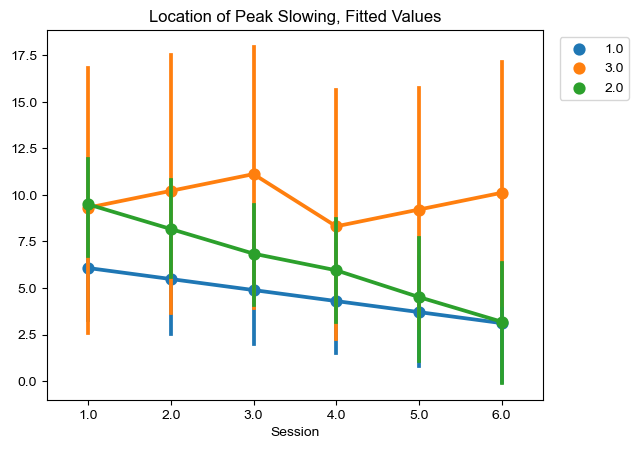

                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       Locpeak  
No. Observations:        163           Method:                   ML       
No. Groups:              29            Scale:                    189.2578 
Min. group size:         3             Log-Likelihood:           -664.1868
Max. group size:         6             Converged:                Yes      
Mean group size:         5.6                                              
--------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------
Intercept                       4.109    4.920  0.835 0.404  -5.535 13.753
C(AgeGroup)[T.2.0]             -0.047    6.991 -0.007 0.995 -13.748 13.654
C(AgeGroup)[T.3.0]              9.309    6.875  1.354 0.176  -4.167 22.784
C(Sex)[T.M]                    10.022    4.6

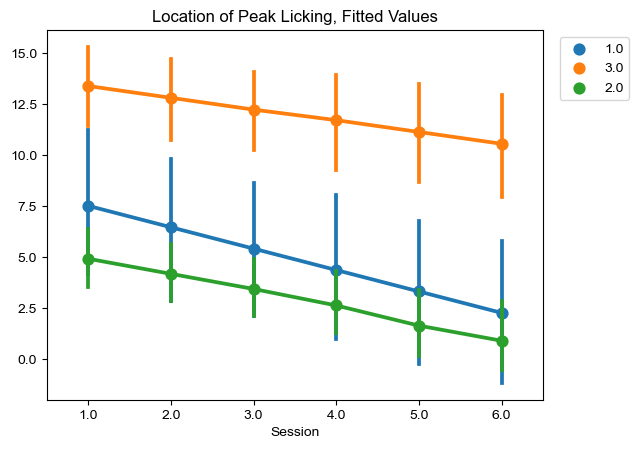

                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Troughprom
No. Observations:       163           Method:                   REML      
No. Groups:             29            Scale:                    25.3215   
Min. group size:        3             Log-Likelihood:           -501.8611 
Max. group size:        6             Converged:                Yes       
Mean group size:        5.6                                               
--------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------
Intercept                       2.526    2.441  1.035 0.301  -2.258  7.309
C(AgeGroup)[T.2.0]             -3.823    3.467 -1.103 0.270 -10.619  2.973
C(AgeGroup)[T.3.0]             -3.605    3.429 -1.051 0.293 -10.327  3.116
C(Sex)[T.M]                    -1.832    2.9

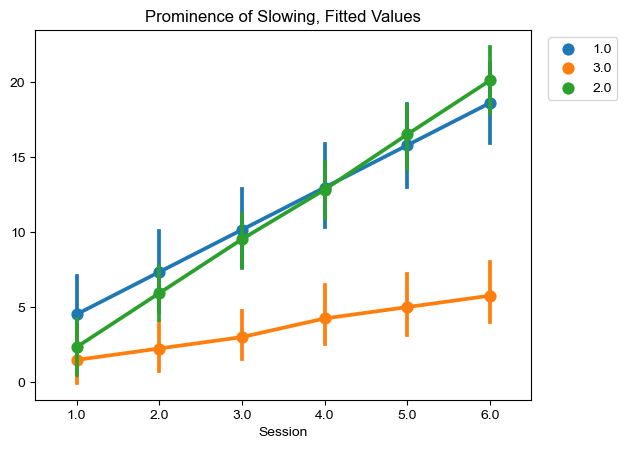

                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Peakprom 
No. Observations:       163           Method:                   REML     
No. Groups:             29            Scale:                    1.1642   
Min. group size:        3             Log-Likelihood:           -259.1578
Max. group size:        6             Converged:                Yes      
Mean group size:        5.6                                              
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       1.861    0.449  4.142 0.000  0.980  2.741
C(AgeGroup)[T.2.0]             -0.306    0.639 -0.479 0.632 -1.559  0.946
C(AgeGroup)[T.3.0]             -1.532    0.630 -2.433 0.015 -2.767 -0.298
C(Sex)[T.M]                    -0.198    0.500 -0.397 0.

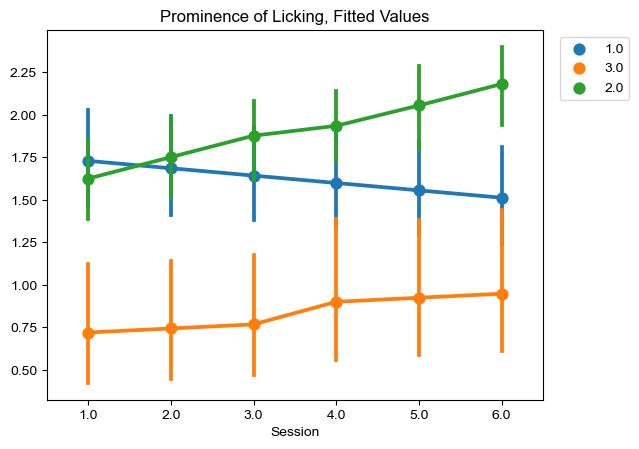

In [38]:
''' Runn LMM on Alternation Reward-Triggered Behavior '''
Loctrough = list(aloc_trough) #slowing
Locpeak = list(aloc_peak) # licking
Troughprom = list(atrough_prom)
Peakprom = list(apeak_prom)

tuples = list(zip(Animal_ID, Session, Sex, Age_Group, Loctrough, Locpeak, Troughprom, Peakprom))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'Sex', 'AgeGroup','Loctrough', 'Locpeak', 'Troughprom', 'Peakprom'])

hue_order = [1.0,3.0,2.0]
mtotal = smf.mixedlm('Loctrough ~ 1 + C(AgeGroup) + Session:C(AgeGroup) + C(Sex) + C(Sex):C(AgeGroup) + Session', groups = 'AnimalID', re_formula = '~1', data=df).fit(reml= True)
print(mtotal.summary())
print(mtotal.wald_test_terms(scalar = False))

sns.pointplot(x = df['Session'], y = mtotal.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('Location of Peak Slowing, Fitted Values')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

mtotal = smf.mixedlm('Locpeak ~ 1 + C(AgeGroup) + Session:C(AgeGroup) + C(Sex) + C(Sex):C(AgeGroup) + Session', groups = 'AnimalID', re_formula = '~1', data=df).fit(reml= False)
print(mtotal.summary())
print(mtotal.wald_test_terms(scalar = False))

sns.pointplot(x = df['Session'], y = mtotal.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('Location of Peak Licking, Fitted Values')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

mtotal = smf.mixedlm('Troughprom ~ 1 + C(AgeGroup) + Session:C(AgeGroup) + C(Sex) + C(Sex):C(AgeGroup) + Session', groups = 'AnimalID', re_formula = '~1', data=df).fit(reml= True)
print(mtotal.summary())
print(mtotal.wald_test_terms(scalar = False))

sns.pointplot(x = df['Session'], y = mtotal.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('Prominence of Slowing, Fitted Values')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

mtotal = smf.mixedlm('Peakprom ~ 1 + C(AgeGroup) + Session:C(AgeGroup) + C(Sex) + C(Sex):C(AgeGroup) + Session', groups = 'AnimalID', re_formula = '~1', data=df).fit(reml= True)
print(mtotal.summary())
print(mtotal.wald_test_terms(scalar = False))

sns.pointplot(x = df['Session'], y = mtotal.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('Prominence of Licking, Fitted Values')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

Alternation Behavior Model Results:
1. Three models converge with REML. Model of location of peak licking converged only with ML.
2. In general, reward-triggered slowing and licking behavior in the alternation phase does not differ by age group or in the interaction of age group with session. 
3. The exceptions are that age predicted less reward-triggered licking and the age interacted with session to predict smaller changes in slowing  magnitude over days. 

In [78]:
''' Calculate Total Non-Consummatory Licks / Trial & Frac. Licks in Opposite Zone / Trial '''

#session arrays
nclickb_rate = []
opplickb_rate = []
nclicka_rate = []
opplicka_rate = []

#animals arrays
mnclickb_rate = []
mopplickb_rate = []
mnclicka_rate = []
mopplicka_rate = []

for m, session in zip(mice,sessions):
    
    nclickb = []
    nclicka = []
    opplickb = [] 
    opplicka = [] 

    for s in session:
        
        #get behavioral data
        d = data[m][s]
        raw = d['raw']
        speed = raw.item().get('speed')
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        lick_ct = d['reward_data']['lick_ct']
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1)
        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1:
            dt = dt[dt != 0]
        
        # remove reward data pertaining to dark trials & skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            trial = raw.item().get('correctedtrial')
            
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0,np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
                
            skippedtrials = np.setdiff1d(alltrial,np.unique(trial))
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            
        except AttributeError:
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
            skippedtrials = []
        
        centers = np.array(reward['centers'][keep_idx])
        trials = np.array(reward['trials'][keep_idx])
        misses = reward['missed'][keep_idx].astype(bool)
        requests = ~misses 
        


        # get indices for reward zone (center ±25cm) & opp reward zone
        start_idx = []
        oppstart_idx = []
        end_idx = [] 
        oppend_idx = []
        
        for t, c in zip(trials, centers):
            trial_pos = posx.copy()
            start_trial_ind = np.where(trial == t)[0][0]
            t_posx = trial_pos[trial == t]

            zone_start = c - 25 
            zone_end = c + 25
            
            if c == 270: 
                oppzone_start = 370 - 25
                oppzone_end = 370 + 25
            else: 
                oppzone_start = 270 - 25
                oppzone_end = 270 + 25
            
            s_idx = np.argmin(np.abs(t_posx - zone_start)) 
            st_idx = s_idx + start_trial_ind
            e_idx = np.argmin(np.abs(t_posx[s_idx:] - zone_end)) + st_idx
            
            start_idx.append(st_idx)
            end_idx.append(e_idx)
            
            sopp_idx = np.argmin(np.abs(t_posx - oppzone_start))
            oppst_idx = sopp_idx + start_trial_ind
            oppe_idx = np.argmin(np.abs(t_posx[sopp_idx:] - oppzone_end)) + oppst_idx
            
            oppstart_idx.append(oppst_idx)
            oppend_idx.append(oppe_idx)
        
        start_idx = np.asarray(start_idx)
        end_idx = np.asarray(end_idx)
        
        oppstart_idx = np.asarray(oppstart_idx)
        oppend_idx = np.asarray(oppend_idx)
        
        # Remove any consummatory licks 
        nclick_ct = lick_ct.copy()
        for i in range(start_idx.shape[0]):
            st = start_idx[i]
            e = end_idx[i] + 1
            nclick_ct[st:e] = False
        
        # Get total nclicks/trial, save block & alternation mean for sessions, collect all values for animals
        ncbrate = []
        ncarate = []
        ncall = []
        
        for t in trials:
            ncall = np.append(ncall, np.sum(nclick_ct[trial == t]))
            if t < 140: 
                ncbrate.append(np.sum(nclick_ct[trial == t]))
            else: 
                ncarate.append(np.sum(nclick_ct[trial == t])) 
        
        nclickb = np.append(nclickb, ncbrate)
        nclicka = np.append(nclickb, ncarate)
        
        nclickb_rate = np.append(nclickb_rate, np.mean(ncbrate))
        nclicka_rate = np.append(nclicka_rate, np.mean(ncarate))
        
        # Get opposite reward zone licks, save block & alternation mean for sessions, collect all values for animals
        # Normalized to total non-con licks on that same trial
        oppbrate = []
        opparate = []
        for i, t in enumerate(trials):
            st = oppstart_idx[i]
            e = oppend_idx[i] + 1
            if t < 140:
                if np.sum(nclick_ct[trial == t]) > 0: 
                    oppbrate.append(np.sum(nclick_ct[st:e]) / np.sum(nclick_ct[trial == t]))
                else:
                    oppbrate.append(0)
            else:
                if np.sum(nclick_ct[trial == t]) > 0: 
                    opparate.append(np.sum(nclick_ct[st:e]) / np.sum(nclick_ct[trial == t]))
                else:
                    opparate.append(0)
        
        opplickb = np.append(opplickb, oppbrate)
        opplicka = np.append(opplickb, opparate)
        
        opplickb_rate = np.append(opplickb_rate, np.mean(oppbrate))
        opplicka_rate = np.append(opplicka_rate, np.mean(opparate))
              
    # get animal arrays
    mnclickb_rate = np.append(mnclickb_rate, np.mean(nclickb))
    mnclicka_rate = np.append(mnclicka_rate, np.mean(nclicka))
    
    mopplickb_rate = np.append(mopplickb_rate, np.mean(opplickb))
    mopplicka_rate = np.append(mopplicka_rate, np.mean(opplicka))
    
# ensure all outputs are saved as arrays
nclickb_rate = np.asarray(nclickb_rate)
nclicka_rate = np.asarray(nclicka_rate)
opplickb_rate = np.asarray(opplickb_rate)
opplicka_rate = np.asarray(opplicka_rate)

mnclickb_rate = np.asarray(mnclickb_rate)
mnclicka_rate = np.asarray(mnclicka_rate)
mopplickb_rate = np.asarray(mopplickb_rate)
mopplicka_rate = np.asarray(mopplicka_rate)

In [80]:
'''Store Session 1 - 6 for Alt & Block in Nested List'''
r = 6

nclickaltseg_aged = [[] * r for i in range(r)]
nclickblockseg_aged = [[] * r for i in range(r)]
nclickaltseg_MA = [[] * r for i in range(r)]
nclickblockseg_MA = [[] * r for i in range(r)]
nclickaltseg_young = [[] * r for i in range(r)]
nclickblockseg_young= [[] * r for i in range(r)]

opplickaltseg_aged = [[] * r for i in range(r)]
opplickblockseg_aged = [[] * r for i in range(r)]
opplickaltseg_MA = [[] * r for i in range(r)]
opplickblockseg_MA = [[] * r for i in range(r)]
opplickaltseg_young = [[] * r for i in range(r)]
opplickblockseg_young= [[] * r for i in range(r)]

sessioncount_young = [[] * r for i in range(r)]
sessioncount_MA = [[] * r for i in range(r)]
sessioncount_aged = [[] * r for i in range(r)]

count = 0
for m, session in zip(mice, sessions): 
    
    session_idx = np.arange(0 + count, len(session) + count)
    count += len(session)
    
    if m in SM_aged_mice:
        for s in range(0, len(session_idx)):
            nclickaltseg_aged[s] = np.append(nclickaltseg_aged[s],nclicka_rate[session_idx][s])
            nclickblockseg_aged[s] = np.append(nclickblockseg_aged[s],nclickb_rate[session_idx][s])
            opplickaltseg_aged[s] = np.append(opplickaltseg_aged[s],opplicka_rate[session_idx][s])
            opplickblockseg_aged[s] = np.append(opplickblockseg_aged[s],opplickb_rate[session_idx][s])
            sessioncount_aged[s] = np.append(sessioncount_aged[s], s + 1)
            
    elif m in SM_MA_mice:
        for s in range(0, len(session_idx)):
            nclickaltseg_MA[s] = np.append(nclickaltseg_MA[s],nclicka_rate[session_idx][s])
            nclickblockseg_MA[s] = np.append(nclickblockseg_MA[s],nclickb_rate[session_idx][s])
            opplickaltseg_MA[s] = np.append(opplickaltseg_MA[s],opplicka_rate[session_idx][s])
            opplickblockseg_MA[s] = np.append(opplickblockseg_MA[s],opplickb_rate[session_idx][s])
            sessioncount_MA[s] = np.append(sessioncount_MA[s], s + 1)
        
    else:
        for s in range(0, len(session_idx)):
            nclickaltseg_young[s] = np.append(nclickaltseg_young[s],nclicka_rate[session_idx][s])
            nclickblockseg_young[s] = np.append(nclickblockseg_young[s],nclickb_rate[session_idx][s])
            opplickaltseg_young[s] = np.append(opplickaltseg_young[s],opplicka_rate[session_idx][s])
            opplickblockseg_young[s] = np.append(opplickblockseg_young[s],opplickb_rate[session_idx][s])
            sessioncount_young[s] = np.append(sessioncount_young[s], s + 1)

#find means & SEM for each age group over time for alt phase & block phase

nclickalt_meanaged = []
nclickalt_erraged = []
nclickblock_meanaged = []
nclickblock_erraged = []

opplickalt_meanaged = []
opplickalt_erraged = []
opplickblock_meanaged = []
opplickblock_erraged = [] 

for i in range(0,len(nclickaltseg_aged)):
    
    nclickalt_meanaged = np.append(nclickalt_meanaged,np.mean(nclickaltseg_aged[i]))
    nclickalt_erraged = np.append(nclickalt_erraged,stats.sem(nclickaltseg_aged[i]))
    nclickblock_meanaged = np.append(nclickblock_meanaged,np.mean(nclickblockseg_aged[i]))
    nclickblock_erraged = np.append(nclickblock_erraged,stats.sem(nclickblockseg_aged[i]))
    
    opplickalt_meanaged = np.append(opplickalt_meanaged,np.mean(opplickaltseg_aged[i]))
    opplickalt_erraged = np.append(opplickalt_erraged,stats.sem(opplickaltseg_aged[i]))
    opplickblock_meanaged = np.append(opplickblock_meanaged,np.mean(opplickblockseg_aged[i]))
    opplickblock_erraged = np.append(opplickblock_erraged,stats.sem(opplickblockseg_aged[i]))
    
nclickalt_meanMA = []
nclickalt_errMA = []
nclickblock_meanMA = []
nclickblock_errMA = [] 
opplickalt_meanMA = []
opplickalt_errMA = []
opplickblock_meanMA = []
opplickblock_errMA = []   

for i in range(0,len(nclickaltseg_MA)):
    
    nclickalt_meanMA = np.append(nclickalt_meanMA,np.mean(nclickaltseg_MA[i]))
    nclickalt_errMA = np.append(nclickalt_errMA,stats.sem(nclickaltseg_MA[i]))
    nclickblock_meanMA = np.append(nclickblock_meanMA,np.mean(nclickblockseg_MA[i]))
    nclickblock_errMA = np.append(nclickblock_errMA,stats.sem(nclickblockseg_MA[i]))
    
    opplickalt_meanMA = np.append(opplickalt_meanMA,np.mean(opplickaltseg_MA[i]))
    opplickalt_errMA = np.append(opplickalt_errMA,stats.sem(opplickaltseg_MA[i]))
    opplickblock_meanMA = np.append(opplickblock_meanMA,np.mean(opplickblockseg_MA[i]))
    opplickblock_errMA = np.append(opplickblock_errMA,stats.sem(opplickblockseg_MA[i]))
    
nclickalt_meanyoung = []
nclickalt_erryoung = []
nclickblock_meanyoung = []
nclickblock_erryoung = [] 
opplickalt_meanyoung = []
opplickalt_erryoung = []
opplickblock_meanyoung = []
opplickblock_erryoung = []   

for i in range(0,len(nclickaltseg_young)):
    
    nclickalt_meanyoung = np.append(nclickalt_meanyoung,np.mean(nclickaltseg_young[i]))
    nclickalt_erryoung = np.append(nclickalt_erryoung,stats.sem(nclickaltseg_young[i]))
    nclickblock_meanyoung = np.append(nclickblock_meanyoung,np.mean(nclickblockseg_young[i]))
    nclickblock_erryoung = np.append(nclickblock_erryoung,stats.sem(nclickblockseg_young[i]))
    
    opplickalt_meanyoung = np.append(opplickalt_meanyoung,np.mean(opplickaltseg_young[i]))
    opplickalt_erryoung = np.append(opplickalt_erryoung,stats.sem(opplickaltseg_young[i]))
    opplickblock_meanyoung = np.append(opplickblock_meanyoung,np.mean(opplickblockseg_young[i]))
    opplickblock_erryoung = np.append(opplickblock_erryoung,stats.sem(opplickblockseg_young[i]))

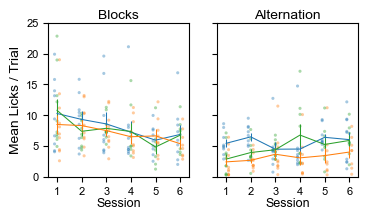

In [81]:
''' Plot Mean Non-Con Lick / Trial [Block & Alt] by Age Group over Sessions (Extended Data Figure 1i)'''

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (4,2), sharey = True)
#fig.suptitle(('Non-Consummatory Licks / Trial'), fontsize = 10, y = 1)
ax1.errorbar(np.arange(1,7,1),nclickblock_meanyoung,yerr = nclickblock_erryoung, linewidth = 0.75, label = 'Young')
ax1.errorbar(np.arange(1,7,1),nclickblock_meanMA,yerr = nclickblock_errMA, linewidth = 0.75, label = 'MA', color = 'C2')
ax1.errorbar(np.arange(1,7,1),nclickblock_meanaged,yerr = nclickblock_erraged, linewidth = 0.75, label = 'Aged', color = 'C1')
ax1.set_title('Blocks', fontsize=10, pad=3)
ax1.set_ylabel('Mean Licks / Trial', fontsize=10, labelpad=3)
ax1.set_xlabel('Session', fontsize=9, labelpad=1)
ax1.set_xticks([1,2,3,4,5,6])
ax1.set_yticks([0,5,10,15,20,25])
ax1.set_ylim([0,25])
ax1.tick_params(labelsize = 8)

ax2.errorbar(np.arange(1,7,1),nclickalt_meanyoung,yerr = nclickalt_erryoung, linewidth = 0.75, label = 'Young')
ax2.errorbar(np.arange(1,7,1),nclickalt_meanMA,yerr = nclickalt_errMA, linewidth = 0.75, label = 'MA', color = 'C2')
ax2.errorbar(np.arange(1,7,1),nclickalt_meanaged, yerr = nclickalt_erraged, linewidth = 0.75, label = 'Aged', color = 'C1')
ax2.set_title('Alternation', fontsize=10, pad=3)
#ax1.legend(loc = 'upper left')
ax2.set_xticks([1,2,3,4,5,6])
ax2.set_xlabel('Session', fontsize=9, labelpad=1)
ax2.tick_params(labelsize = 8)
ax2.set_yticks([0,5,10,15,20,25])

#scatter plot actual data:
for i in range(0,len(bloctrough_aged)):
    ax1.scatter(sessioncount_aged[i] + 0.1, nclickblockseg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax1.scatter(sessioncount_MA[i], nclickblockseg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax1.scatter(sessioncount_young[i] - 0.1, nclickblockseg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax2.scatter(sessioncount_aged[i] + 0.1, nclickaltseg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax2.scatter(sessioncount_MA[i], nclickaltseg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax2.scatter(sessioncount_young[i] - 0.1,nclickaltseg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#plt.savefig(save_folder + 'time_nclickblockalt_avganimal.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'time_nclickblockalt_avganimal.svg', dpi=400, bbox_inches='tight')
plt.show()

                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Lickblock
No. Observations:       163           Method:                   REML     
No. Groups:             29            Scale:                    10.7162  
Min. group size:        3             Log-Likelihood:           -432.1781
Max. group size:        6             Converged:                Yes      
Mean group size:        5.6                                              
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      11.036    1.616  6.831 0.000  7.870 14.203
C(AgeGroup)[T.2.0]             -0.996    2.128 -0.468 0.640 -5.166  3.174
C(AgeGroup)[T.3.0]             -2.996    2.101 -1.426 0.154 -7.115  1.123
C(Sex)[T.M]                    -1.220    1.782 -0.684 0.

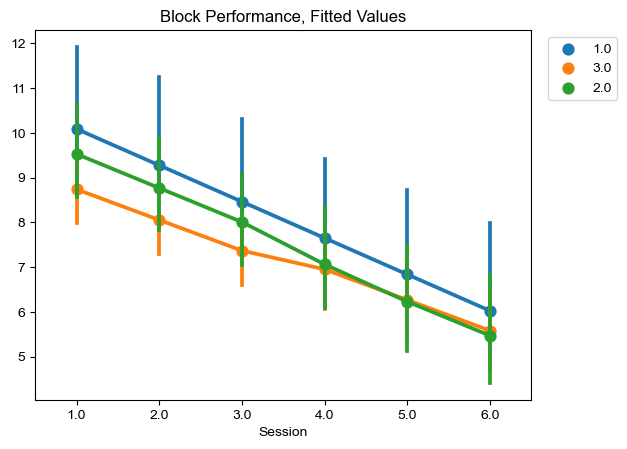

                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Lickalt  
No. Observations:       163           Method:                   REML     
No. Groups:             29            Scale:                    6.3405   
Min. group size:        3             Log-Likelihood:           -389.0662
Max. group size:        6             Converged:                Yes      
Mean group size:        5.6                                              
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       5.171    1.136  4.553 0.000  2.945  7.398
C(AgeGroup)[T.2.0]             -3.020    1.507 -2.004 0.045 -5.973 -0.066
C(AgeGroup)[T.3.0]             -3.861    1.486 -2.598 0.009 -6.774 -0.949
C(Sex)[T.M]                    -1.026    1.193 -0.861 0.

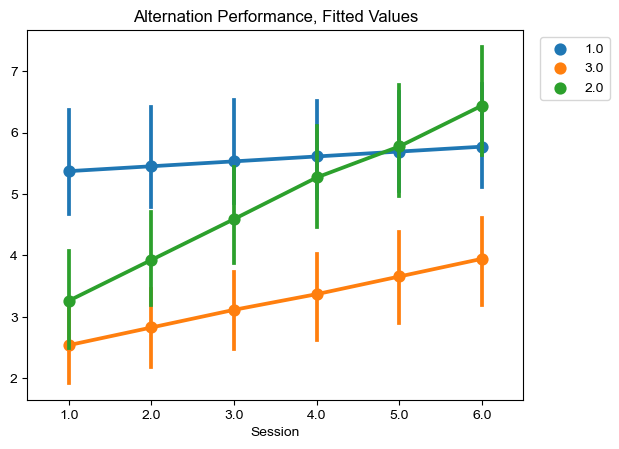

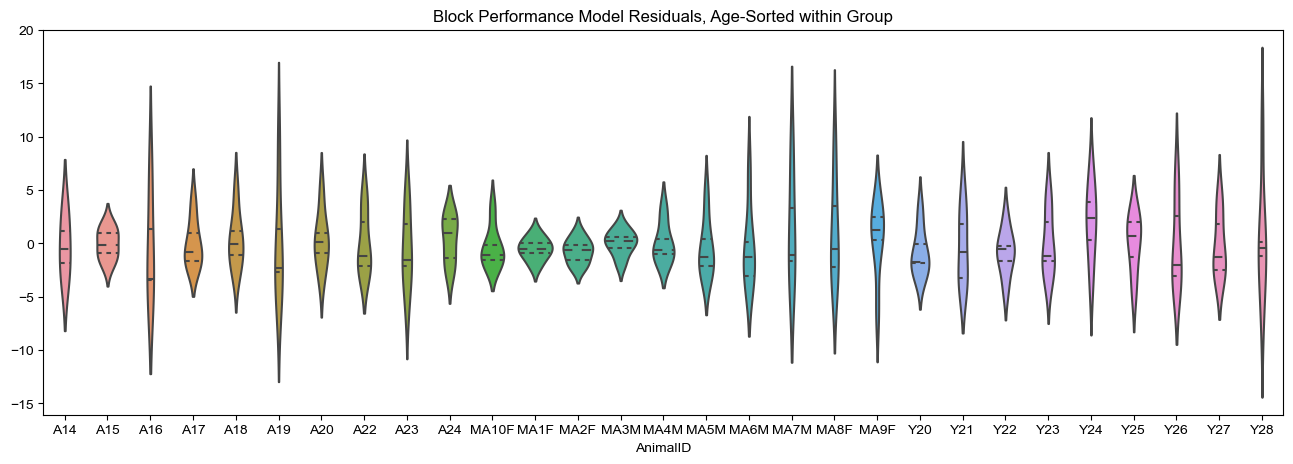

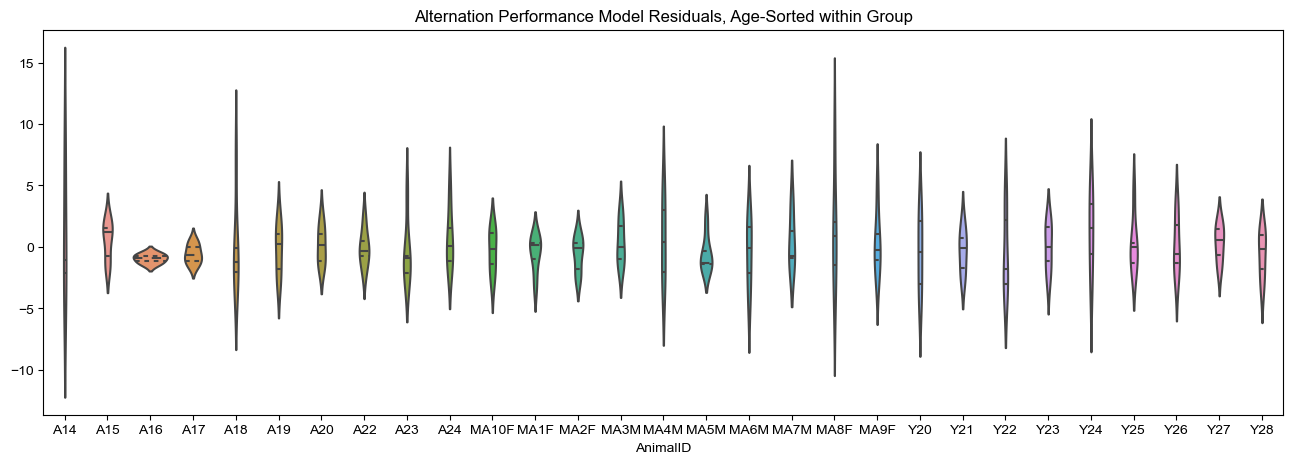

In [83]:
''' Block vs. Alt NC Lick / Trial LMM '''

# Collect all relevant data into pandas dataframe
Animal_ID = list(seshmice)
Session = list(seshcount)
Sex = list(sexes)
Age = list(seshagem)
Age_Group = list(seshage)
Reward_Order = list(rewardacenters)
Lickblock = list(nclickb_rate)
Lickalt = list(nclicka_rate)
Lickerroralt = list(opplicka_rate)
Lickerrorblock = list(opplickb_rate)

tuples = list(zip(Animal_ID, Session, Sex, Age, Age_Group, Reward_Order, Lickblock, Lickalt, Lickerroralt, Lickerrorblock))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'Sex', 'Age', 'AgeGroup','RewardOrder','Lickblock', 'Lickalt', 'Lickerroralt', 'Lickerrorblock'])

# Get LMM, Print Results, Plot Residuals
hue_order = [1.0,3.0,2.0]
mblock = smf.mixedlm('Lickblock ~ 1 + C(AgeGroup) + C(AgeGroup):C(Sex) + C(Sex) + C(RewardOrder) + Session:C(AgeGroup) + Session', groups = 'AnimalID', re_formula = '~1', data=df).fit(reml= True)
#mblock = smf.mixedlm('ReqBlock ~ 1 + C(AgeGroup) + C(Sex) + Session', groups = 'AnimalID', re_formula = '~1 + Session', data=df).fit(reml= False)
print(mblock.summary())
print(mblock.wald_test_terms(scalar = False)) 

sns.pointplot(x = df['Session'], y = mblock.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('Block Performance, Fitted Values')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

malt = smf.mixedlm('Lickalt ~ 1 + C(AgeGroup) + C(Sex) + C(AgeGroup):C(Sex) + C(RewardOrder) + Session:C(AgeGroup) + Session', groups = 'AnimalID', re_formula = '~1', data=df).fit(reml= True)
print(malt.summary())
print(malt.wald_test_terms(scalar = False))

sns.pointplot(x = df['Session'], y = malt.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('Alternation Performance, Fitted Values')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

#Residual Plots
fig, ax = plt.subplots(figsize = (16,5))
df['blockresid'] = mblock.resid
sns.violinplot(x = df['AnimalID'], y = mblock.resid, inner = 'quartile', ax = ax)
plt.title('Block Performance Model Residuals, Age-Sorted within Group')
plt.show()

fig, ax = plt.subplots(figsize = (16,5))
df['altresid'] = malt.resid
sns.violinplot(x = df['AnimalID'], y = malt.resid, inner = 'quartile', ax = ax)
plt.title('Alternation Performance Model Residuals, Age-Sorted within Group')
plt.show()


Lick Rate Model Results:

1. Models converge w/ REML.
2. Age predicts lower alternation lick rate.
3. Block lick rate decreases over sessions for all groups. 

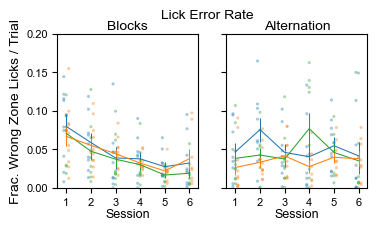

In [82]:
''' Plot Mean Norm Opp Zone Lick / Trial [Block & Alt] by Age Group over Sessions (Extended Data Figure 1j)'''

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (4,2), sharey = True)
fig.suptitle(('Lick Error Rate'), fontsize = 10, y = 1)
ax1.errorbar(np.arange(1,7,1),opplickblock_meanyoung,yerr = opplickblock_erryoung, linewidth = 0.75, label = 'Young')
ax1.errorbar(np.arange(1,7,1),opplickblock_meanMA,yerr = opplickblock_errMA, linewidth = 0.75, label = 'MA', color = 'C2')
ax1.errorbar(np.arange(1,7,1),opplickblock_meanaged,yerr = opplickblock_erraged, linewidth = 0.75, label = 'Aged', color = 'C1')
ax1.set_title('Blocks', fontsize=10, pad=3)
ax1.set_xticks(ticks = [1,2,3,4,5,6])
ax1.set_ylabel('Frac. Wrong Zone Licks / Trial', fontsize=10, labelpad=3)
ax1.set_xlabel('Session', fontsize=9, labelpad=1)
ax1.tick_params(labelsize = 8)

ax2.errorbar(np.arange(1,7,1),opplickalt_meanyoung,yerr = opplickalt_erryoung, linewidth = 0.75, label = 'Young')
ax2.errorbar(np.arange(1,7,1),opplickalt_meanMA,yerr = opplickalt_errMA, linewidth = 0.75, label = 'MA', color = 'C2')
ax2.errorbar(np.arange(1,7,1),opplickalt_meanaged, yerr = opplickalt_erraged, linewidth = 0.75, label = 'Aged', color = 'C1')
ax2.set_title('Alternation', fontsize=10, pad=3)
#ax1.legend(loc = 'upper left')
ax2.set_xlabel('Session', fontsize=9, labelpad=1)
ax2.set_xticks(ticks = [1,2,3,4,5,6])
ax2.tick_params(labelsize = 8)
ax2.set_yticks([0,0.05,0.10,0.15,0.20])
ax2.set_ylim([0,0.20])

#scatter plot actual data:
for i in range(0,len(bloctrough_aged)):
    ax1.scatter(sessioncount_aged[i] + 0.1, opplickblockseg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax1.scatter(sessioncount_MA[i], opplickblockseg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax1.scatter(sessioncount_young[i] - 0.1, opplickblockseg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax2.scatter(sessioncount_aged[i] + 0.1, opplickaltseg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax2.scatter(sessioncount_MA[i], opplickaltseg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax2.scatter(sessioncount_young[i] - 0.1,opplickaltseg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
#plt.savefig(save_folder + 'time_opplickblockalt_avganimal.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'time_opplickblockalt_avganimal.svg', dpi=400, bbox_inches='tight')
plt.show()

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     Lickerrorblock
No. Observations:      163         Method:                 REML          
No. Groups:            29          Scale:                  0.0006        
Min. group size:       3           Log-Likelihood:         311.8695      
Max. group size:       6           Converged:              Yes           
Mean group size:       5.6                                               
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.084    0.013  6.342 0.000  0.058  0.110
C(AgeGroup)[T.2.0]             -0.005    0.017 -0.280 0.779 -0.039  0.029
C(AgeGroup)[T.3.0]             -0.014    0.017 -0.791 0.429 -0.047  0.020
C(Sex)[T.M]                    -0.005    0.015 -0.354 0.

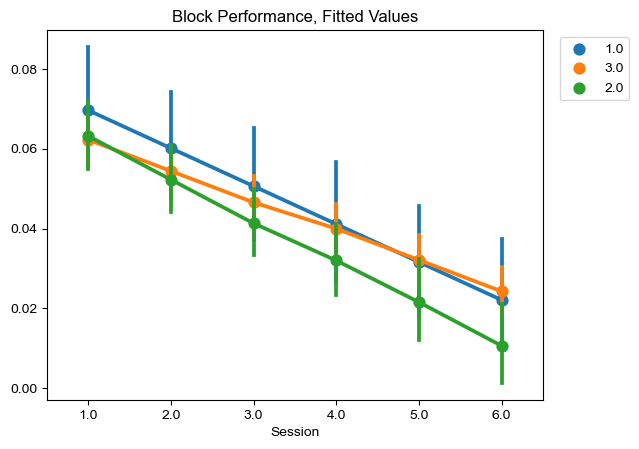

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Lickerroralt
No. Observations:      163          Method:                  REML        
No. Groups:            29           Scale:                   0.0011      
Min. group size:       3            Log-Likelihood:          273.7370    
Max. group size:       6            Converged:               Yes         
Mean group size:       5.6                                               
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.058    0.015  3.782 0.000  0.028  0.088
C(AgeGroup)[T.2.0]             -0.010    0.020 -0.475 0.634 -0.049  0.030
C(AgeGroup)[T.3.0]             -0.032    0.020 -1.622 0.105 -0.072  0.007
C(Sex)[T.M]                     0.004    0.016  0.244 0.

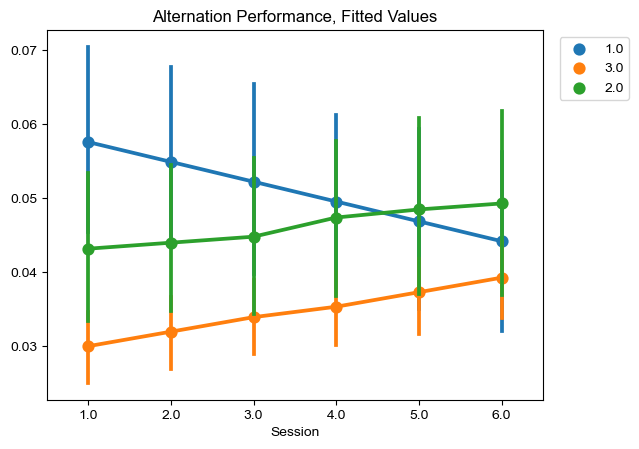

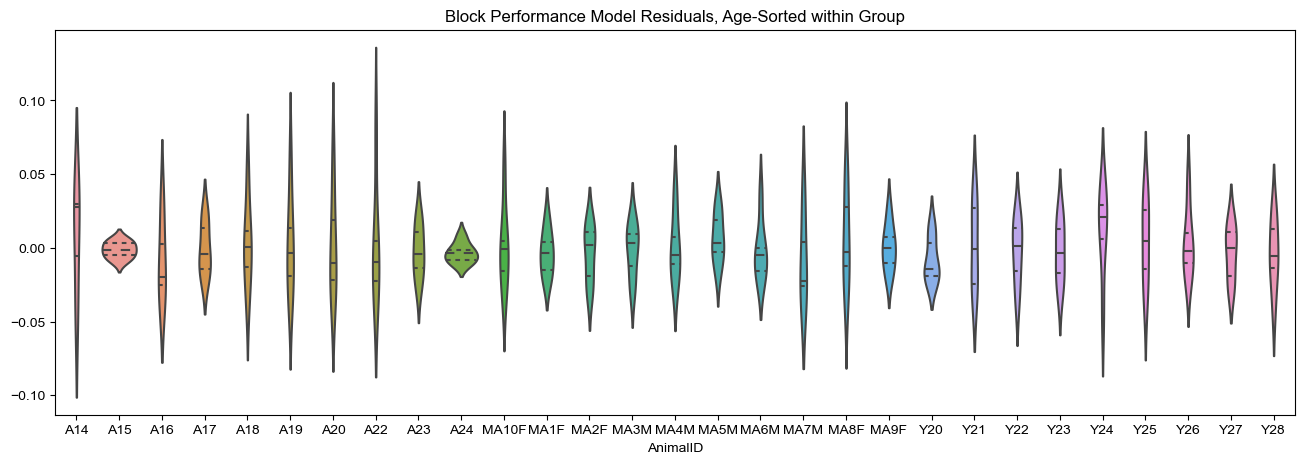

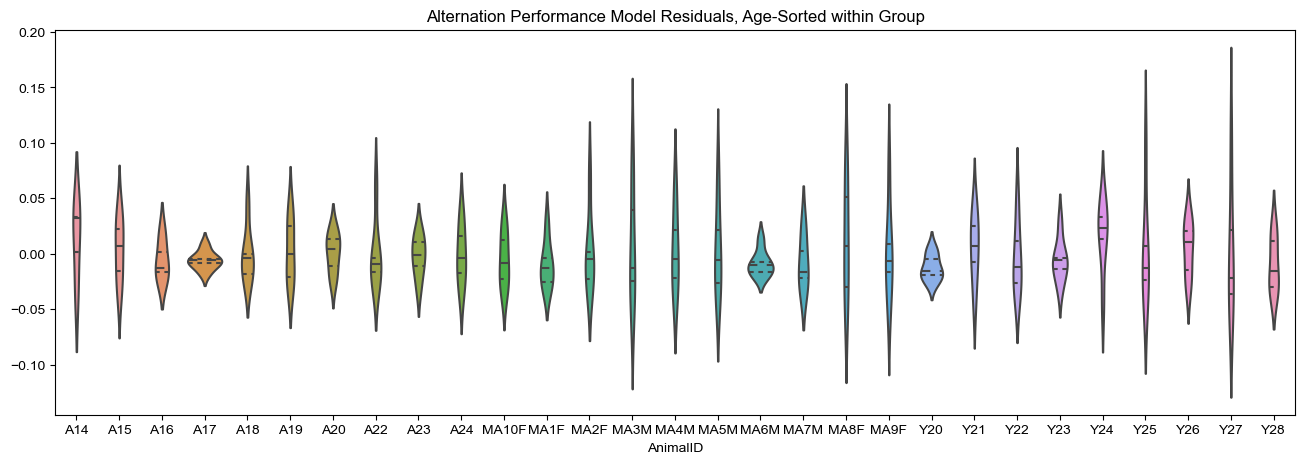

In [84]:
''' Block vs. Alt Lick Error / Trial LMM '''
mblock = smf.mixedlm('Lickerrorblock ~ 1 + C(AgeGroup) + C(AgeGroup):C(Sex) + C(Sex) + C(RewardOrder) + Session:C(AgeGroup) + Session', groups = 'AnimalID', re_formula = '~1', data=df).fit(reml=True)
#mblock = smf.mixedlm('ReqBlock ~ 1 + C(AgeGroup) + C(Sex) + Session', groups = 'AnimalID', re_formula = '~1 + Session', data=df).fit(reml= False)
print(mblock.summary())
print(mblock.wald_test_terms(scalar = False)) 

sns.pointplot(x = df['Session'], y = mblock.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('Block Performance, Fitted Values')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

malt = smf.mixedlm('Lickerroralt ~ 1 + C(AgeGroup) + C(Sex) + C(AgeGroup):C(Sex) + C(RewardOrder) + Session:C(AgeGroup) + Session', groups = 'AnimalID', re_formula = '~1', data=df).fit(reml= True)
print(malt.summary())
print(malt.wald_test_terms(scalar = False))

sns.pointplot(x = df['Session'], y = malt.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('Alternation Performance, Fitted Values')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

# Residual plots
fig, ax = plt.subplots(figsize = (16,5))
df['blockresid'] = mblock.resid
sns.violinplot(x = df['AnimalID'], y = mblock.resid, inner = 'quartile', ax = ax)
plt.title('Block Performance Model Residuals, Age-Sorted within Group')
plt.show()

fig, ax = plt.subplots(figsize = (16,5))
df['altresid'] = malt.resid
sns.violinplot(x = df['AnimalID'], y = malt.resid, inner = 'quartile', ax = ax)
plt.title('Alternation Performance Model Residuals, Age-Sorted within Group')
plt.show()


Lick Error Rate Model Results:

1. Models converge w/ REML.
2. Block lick rate decreases over sessions for all groups. 
3. No age differences in lick error rate during blocks or alternation